## Analyze the telco customer churn dataset from the uploaded CSV file. 
### Perform a comprehensive end-to-end analysis including:

Load and explore the dataset structure
Data cleaning and preprocessing (handle missing values, encode categorical variables)
Comprehensive EDA with visualizations to identify churn patterns
Build multiple predictive models (Logistic Regression, Random Forest, XGBoost)
Model evaluation and comparison using ROC AUC, Precision, Recall, F1-Score
Customer segmentation and risk scoring
Generate actionable business insights and retention strategies
Create visualizations for key findings.

Focus on business value and provide clear recommendations for customer retention strategies based on the analysis.

In [ ]:
# Install XGBoost
!pip install xgboost

In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score, precision_recall_curve, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
import matplotlib.ticker as mtick
from scipy import stats

# Setting plot style
plt.style.use('seaborn-v0_8')
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [4]:
# 1. Load and explore the dataset structure

# Load the dataset
df = pd.read_csv("Telco-Customer-Churn.csv")

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
df.info()
print("\nDataset Description:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nSample of data:")
df.head()

Dataset Shape: (7043, 21)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  P

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

## Check the unique values in each categorical column

In [5]:
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"{col}: {df[col].unique()}")
    print(f"Count: {df[col].nunique()}")
    print("-" * 50)

customerID: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Count: 7043
--------------------------------------------------
gender: ['Female' 'Male']
Count: 2
--------------------------------------------------
Partner: ['Yes' 'No']
Count: 2
--------------------------------------------------
Dependents: ['No' 'Yes']
Count: 2
--------------------------------------------------
PhoneService: ['No' 'Yes']
Count: 2
--------------------------------------------------
MultipleLines: ['No phone service' 'No' 'Yes']
Count: 3
--------------------------------------------------
InternetService: ['DSL' 'Fiber optic' 'No']
Count: 3
--------------------------------------------------
OnlineSecurity: ['No' 'Yes' 'No internet service']
Count: 3
--------------------------------------------------
OnlineBackup: ['Yes' 'No' 'No internet service']
Count: 3
--------------------------------------------------
DeviceProtection: ['No' 'Yes' 'No internet service']
Count: 3
-------

## Check the TotalCharges column as it appears to be a numeric column stored as an object

In [6]:
print(df['TotalCharges'].head(20))
print("\nCheck if there are any non-numeric values in TotalCharges:")
non_numeric = pd.to_numeric(df['TotalCharges'], errors='coerce').isna()
print(f"Number of non-numeric values: {non_numeric.sum()}")
print(df.loc[non_numeric, 'TotalCharges'])

0       29.85
1      1889.5
2      108.15
3     1840.75
4      151.65
5       820.5
6      1949.4
7       301.9
8     3046.05
9     3487.95
10     587.45
11      326.8
12     5681.1
13     5036.3
14    2686.05
15    7895.15
16    1022.95
17    7382.25
18     528.35
19     1862.9
Name: TotalCharges, dtype: object

Check if there are any non-numeric values in TotalCharges:
Number of non-numeric values: 11
488      
753      
936      
1082     
1340     
3331     
3826     
4380     
5218     
6670     
6754     
Name: TotalCharges, dtype: object


## Let's check the records with empty TotalCharges

In [7]:
print(df.loc[pd.to_numeric(df['TotalCharges'], errors='coerce').isna(), ['customerID', 'tenure', 'MonthlyCharges', 'TotalCharges']])

      customerID  tenure  MonthlyCharges TotalCharges
488   4472-LVYGI       0           52.55             
753   3115-CZMZD       0           20.25             
936   5709-LVOEQ       0           80.85             
1082  4367-NUYAO       0           25.75             
1340  1371-DWPAZ       0           56.05             
3331  7644-OMVMY       0           19.85             
3826  3213-VVOLG       0           25.35             
4380  2520-SGTTA       0           20.00             
5218  2923-ARZLG       0           19.70             
6670  4075-WKNIU       0           73.35             
6754  2775-SEFEE       0           61.90             


## 2. Data Cleaning and Preprocessing

In [8]:
# Convert TotalCharges to numeric, replacing empty strings with NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Since the tenure is 0 for these customers, we can set their TotalCharges to 0 or to their MonthlyCharges
# Let's see the relation between tenure, MonthlyCharges, and TotalCharges
print("Correlations:\n")

# First convert TotalCharges to numeric handling NAs
df_corr = df.copy()
df_corr['TotalCharges'] = pd.to_numeric(df_corr['TotalCharges'], errors='coerce')

# Calculate correlations between numeric columns
correlation = df_corr[['tenure', 'MonthlyCharges', 'TotalCharges']].corr()
print(correlation)

# Let's fill missing TotalCharges based on tenure
df.loc[df['tenure'] == 0, 'TotalCharges'] = 0

# Confirm changes
print("\nAfter filling missing values:")
print(df.loc[df['tenure'] == 0, ['customerID', 'tenure', 'MonthlyCharges', 'TotalCharges']])

# Check for any remaining null values
print("\nRemaining missing values:")
print(df.isnull().sum())

Correlations:

                 tenure  MonthlyCharges  TotalCharges
tenure          1.00000        0.247900      0.825880
MonthlyCharges  0.24790        1.000000      0.651065
TotalCharges    0.82588        0.651065      1.000000

After filling missing values:
      customerID  tenure  MonthlyCharges  TotalCharges
488   4472-LVYGI       0           52.55           0.0
753   3115-CZMZD       0           20.25           0.0
936   5709-LVOEQ       0           80.85           0.0
1082  4367-NUYAO       0           25.75           0.0
1340  1371-DWPAZ       0           56.05           0.0
3331  7644-OMVMY       0           19.85           0.0
3826  3213-VVOLG       0           25.35           0.0
4380  2520-SGTTA       0           20.00           0.0
5218  2923-ARZLG       0           19.70           0.0
6670  4075-WKNIU       0           73.35           0.0
6754  2775-SEFEE       0           61.90           0.0

Remaining missing values:
customerID          0
gender              0
SeniorC

## Let's look at the Churn distribution

Churn Distribution:
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


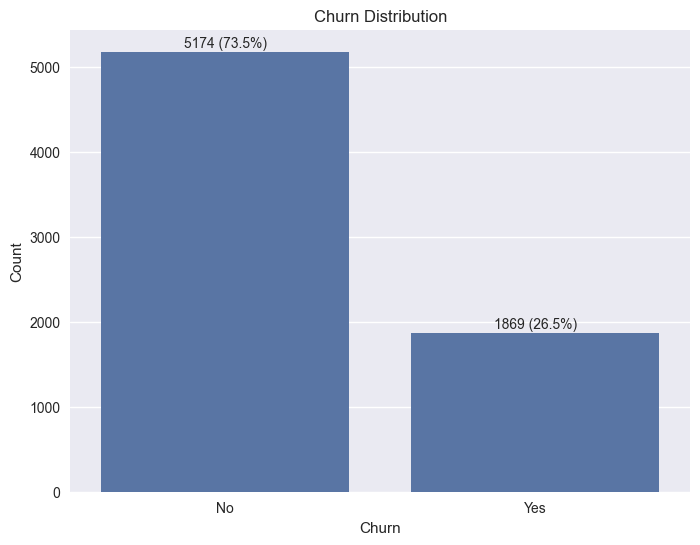

In [9]:
print("Churn Distribution:")
churn_distribution = df['Churn'].value_counts(normalize=True) * 100
print(churn_distribution)

# Create a visualization for churn distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
for i, v in enumerate(df['Churn'].value_counts()):
    plt.text(i, v + 50, f'{v} ({v/len(df)*100:.1f}%)', ha='center')
plt.show()

## 3. Exploratory Data Analysis (EDA)

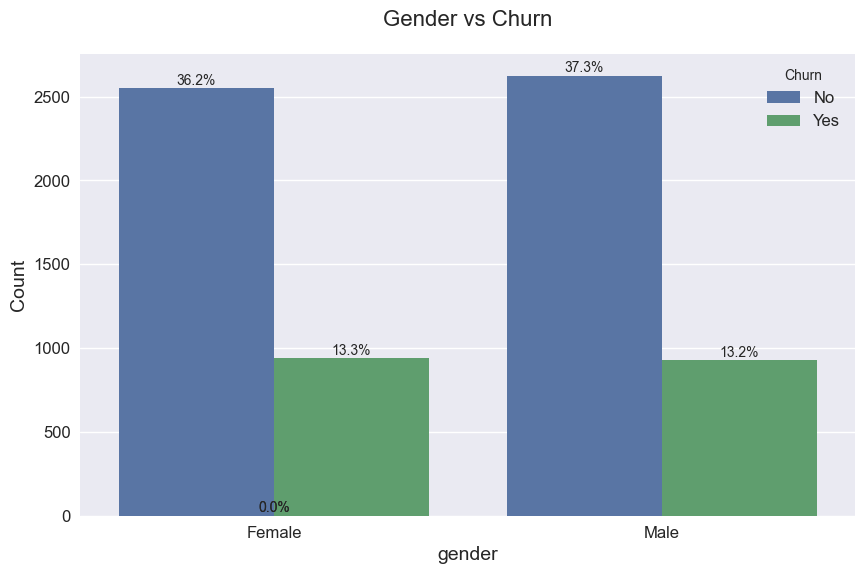

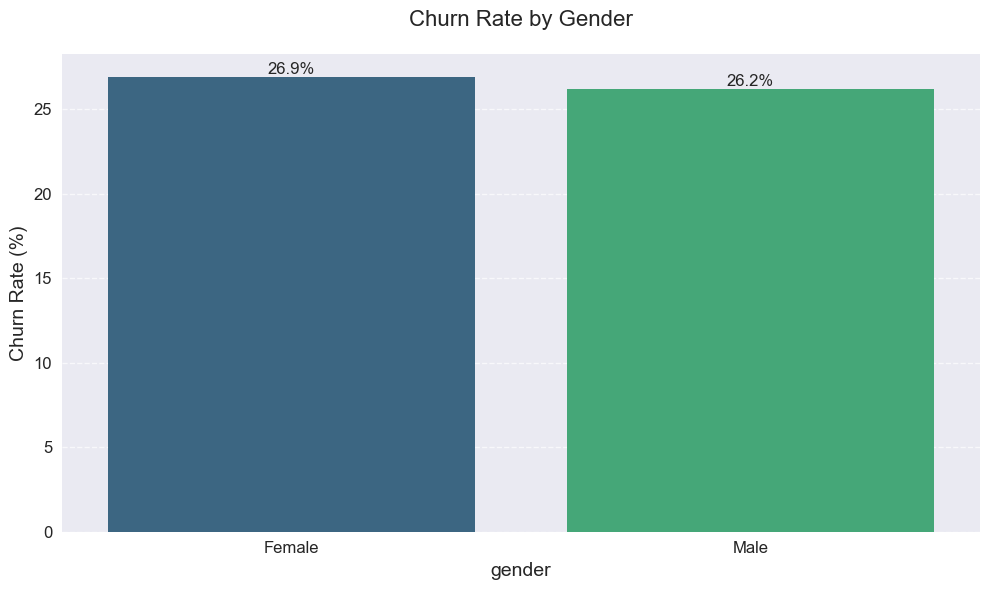

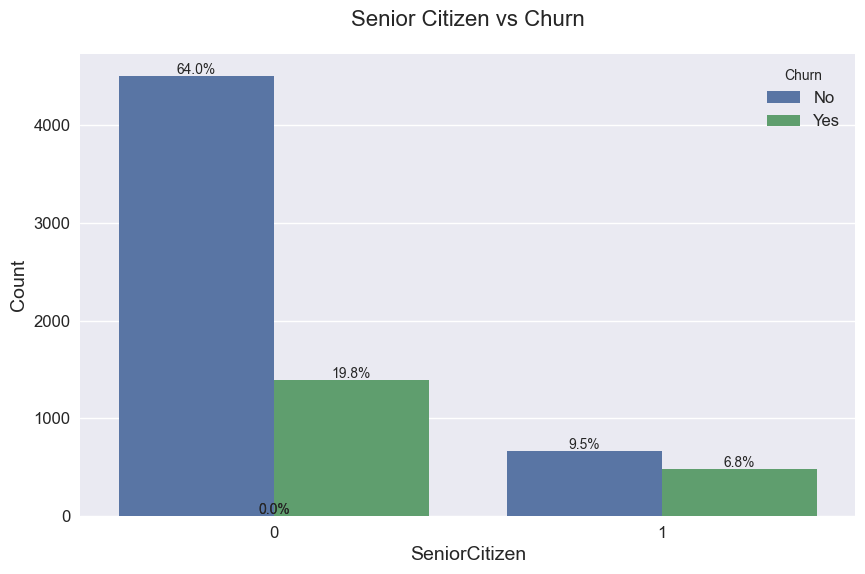

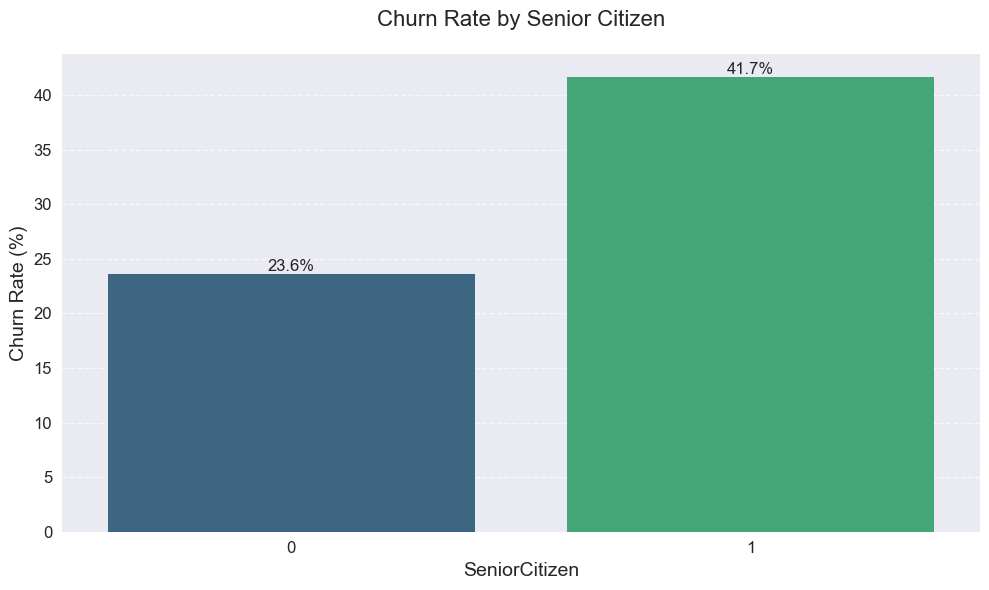

In [10]:
# Let's analyze the relationship between various features and churn

# Function to create a countplot for categorical variables
def plot_categorical(column, title):
    plt.figure(figsize=(10, 6))
    
    # Main plot
    ax = sns.countplot(x=column, hue='Churn', data=df)
    plt.title(f'{title} vs Churn', fontsize=16, pad=20)
    plt.xlabel(column, fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title='Churn', fontsize=12)
    
    # Add percentages at the top of bars
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2.,
                height + 20,
                '{:.1f}%'.format(100 * height/len(df[column])),
                ha="center")
    
    # Add another layer showing the churn rate for each value
    plt.figure(figsize=(10, 6))
    churn_rate = df.groupby(column)['Churn'].apply(lambda x: (x=='Yes').mean() * 100).reset_index()
    churn_rate.columns = [column, 'Churn_Rate']
    
    ax = sns.barplot(x=column, y='Churn_Rate', data=churn_rate, palette='viridis')
    plt.title(f'Churn Rate by {title}', fontsize=16, pad=20)
    plt.xlabel(column, fontsize=14)
    plt.ylabel('Churn Rate (%)', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.1f}%', 
                    (p.get_x() + p.get_width()/2., p.get_height()), 
                    ha='center', va='bottom', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Analyze categorical variables
plot_categorical('gender', 'Gender')
plot_categorical('SeniorCitizen', 'Senior Citizen')

## Continue analyzing important features

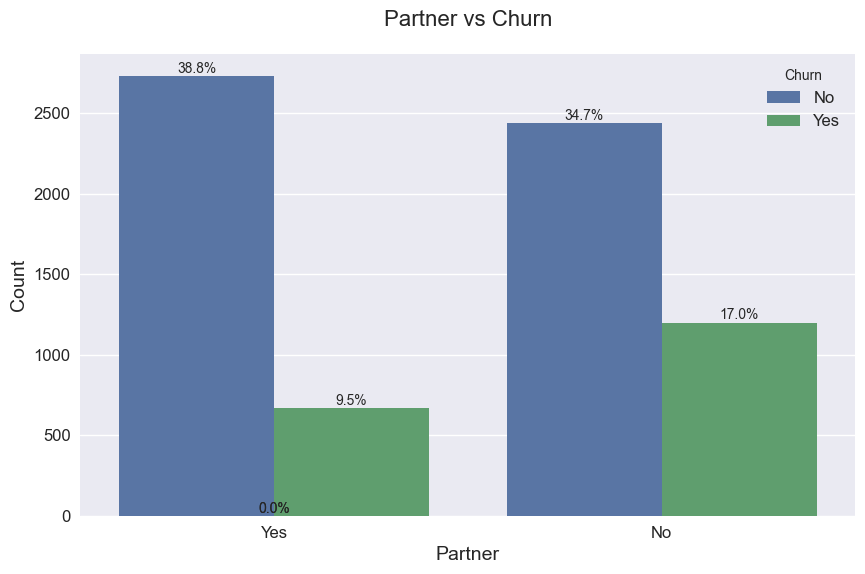

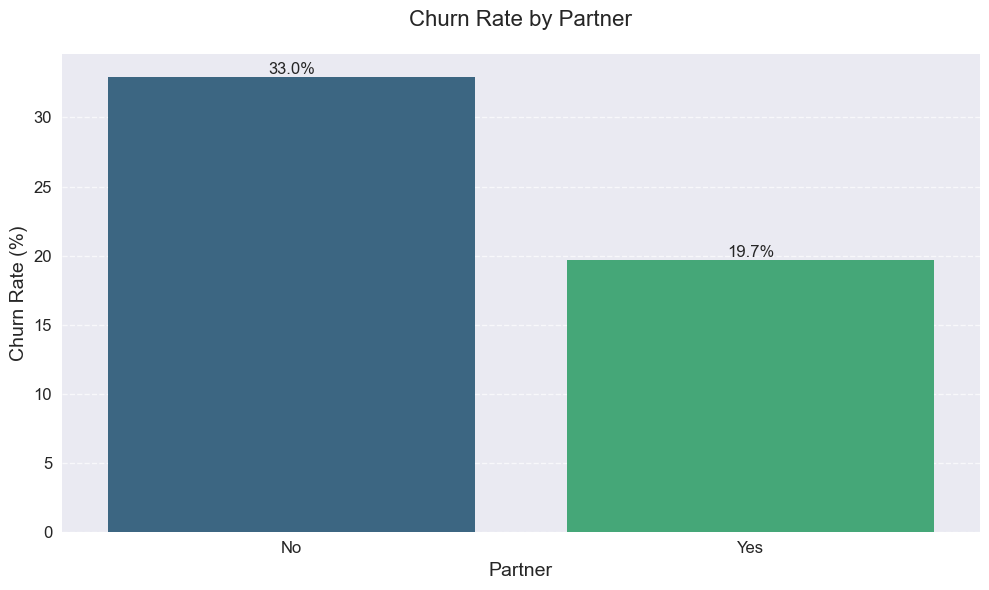

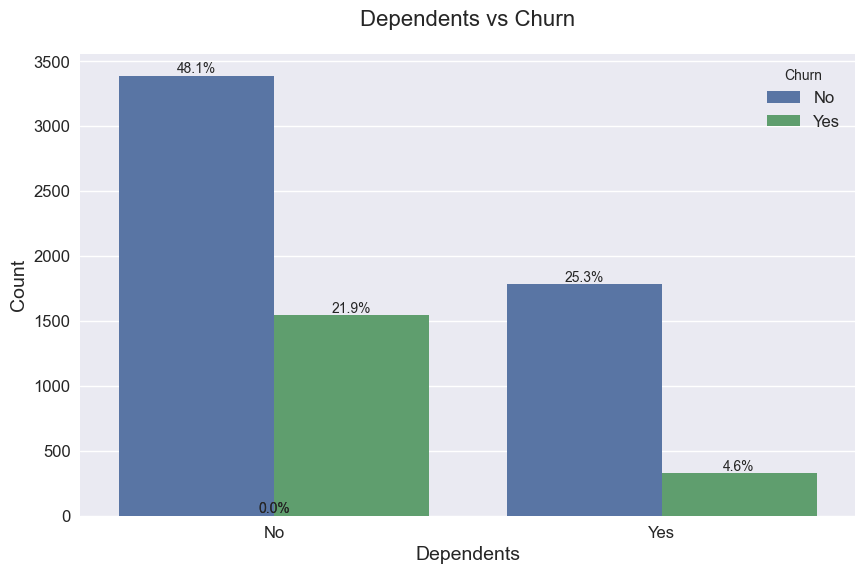

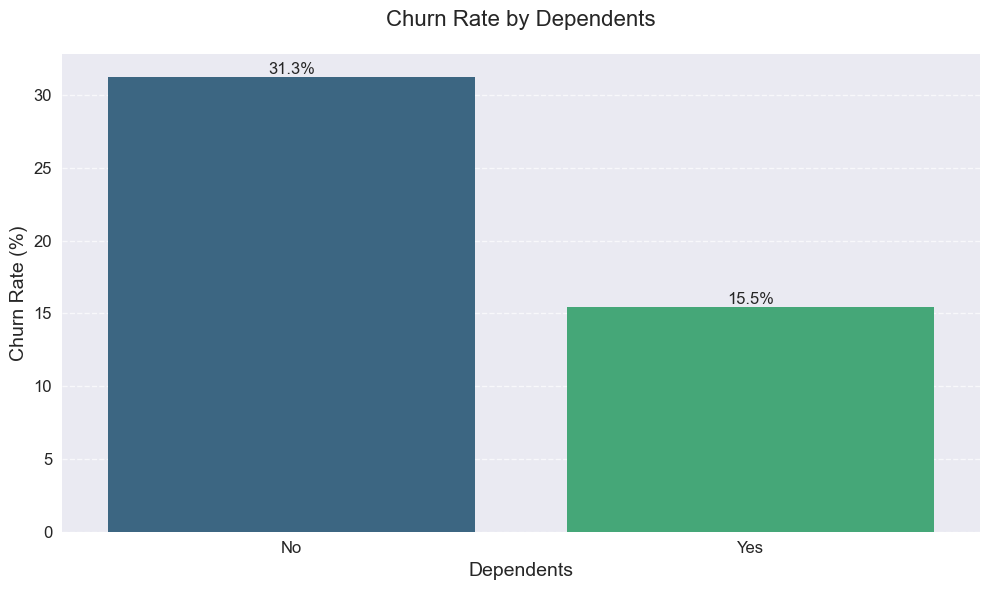

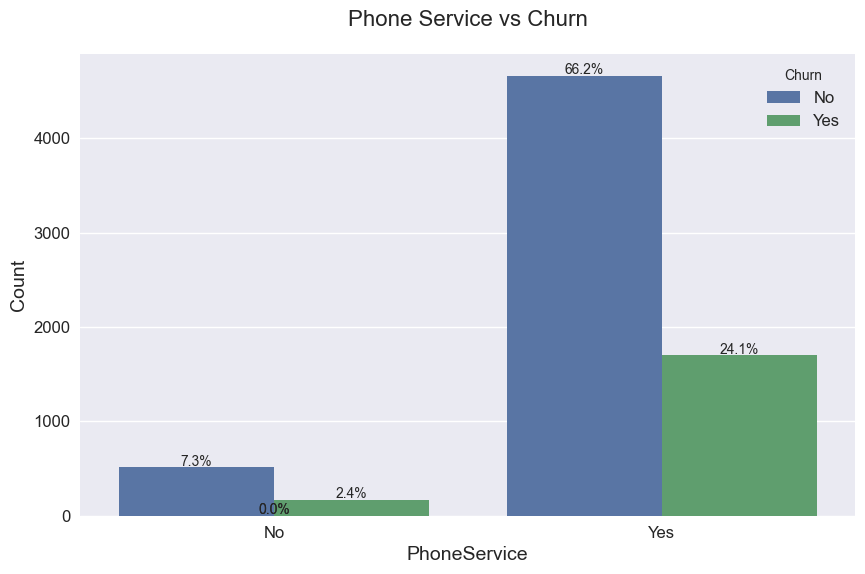

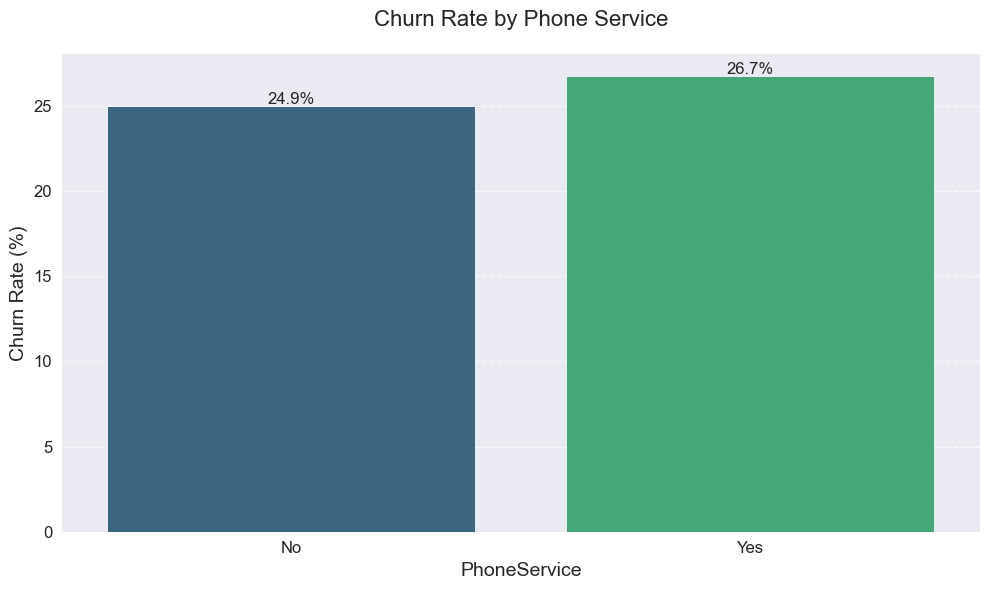

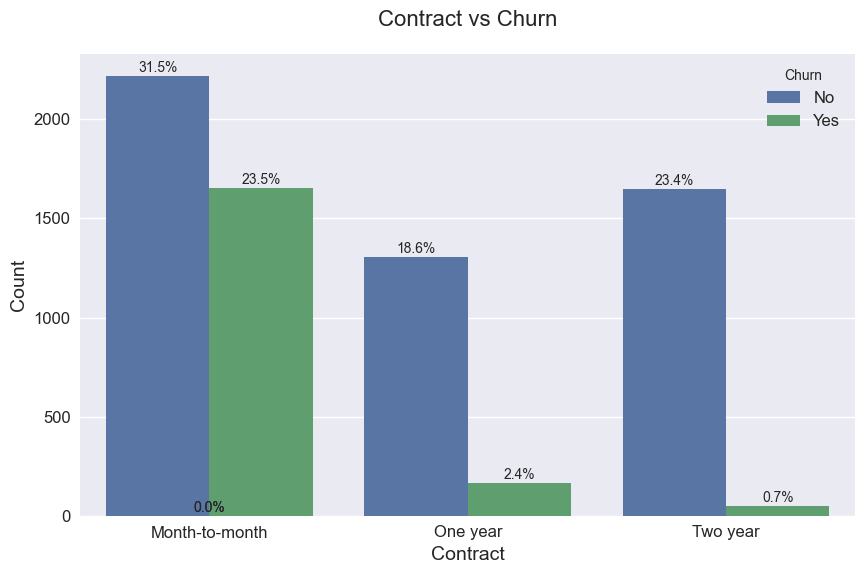

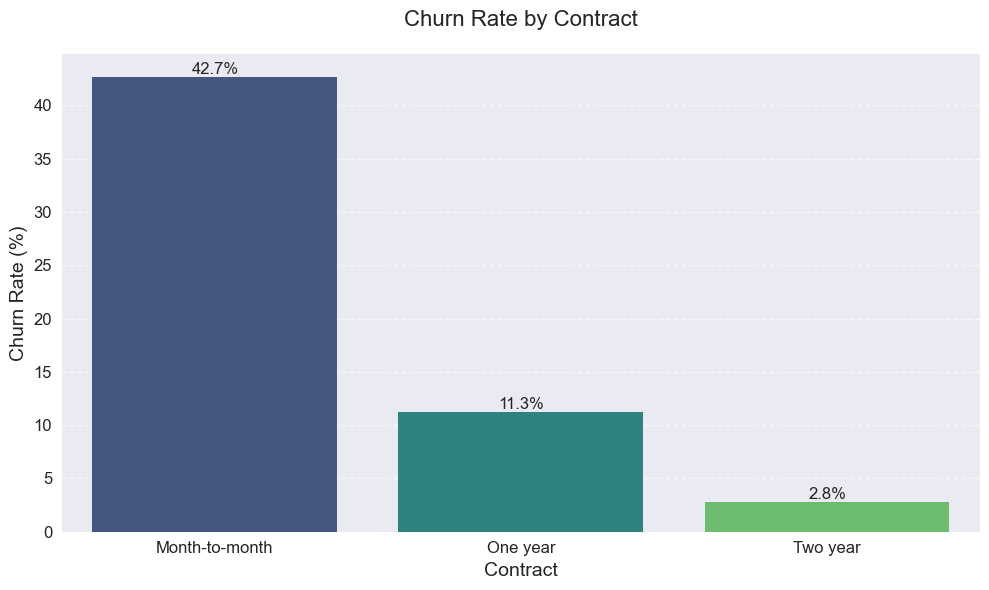

In [11]:
plot_categorical('Partner', 'Partner')
plot_categorical('Dependents', 'Dependents')
plot_categorical('PhoneService', 'Phone Service')
plot_categorical('Contract', 'Contract')

## Analyze internet-related services

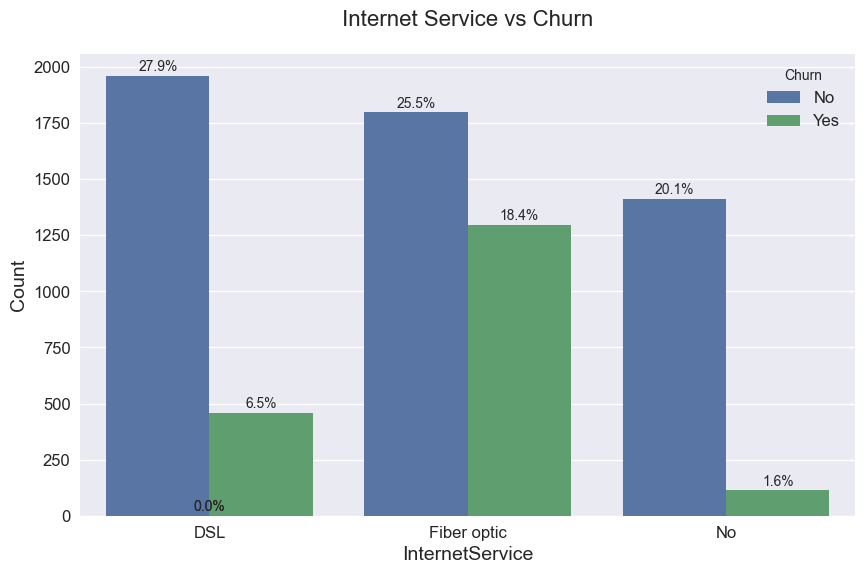

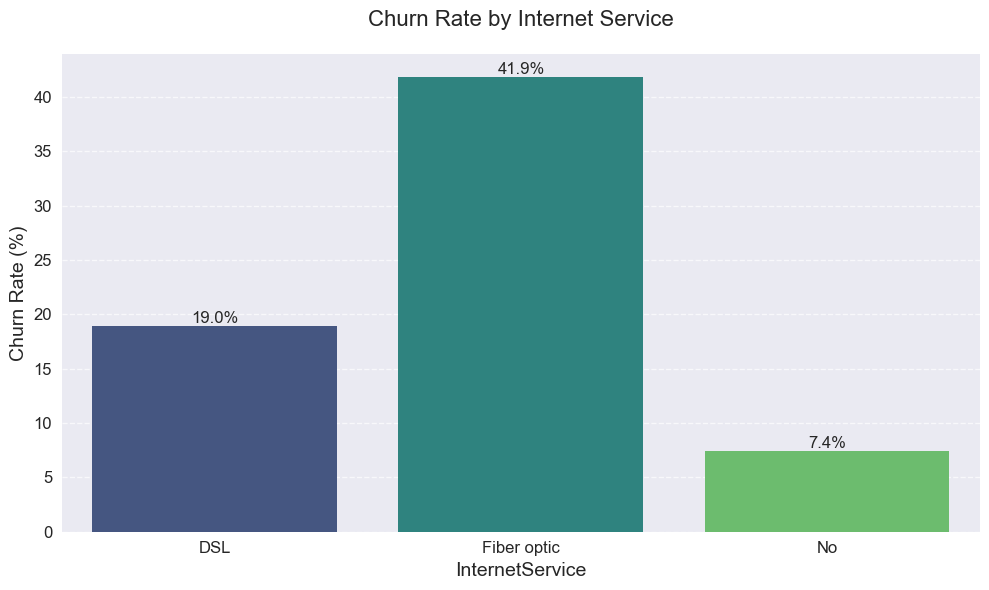

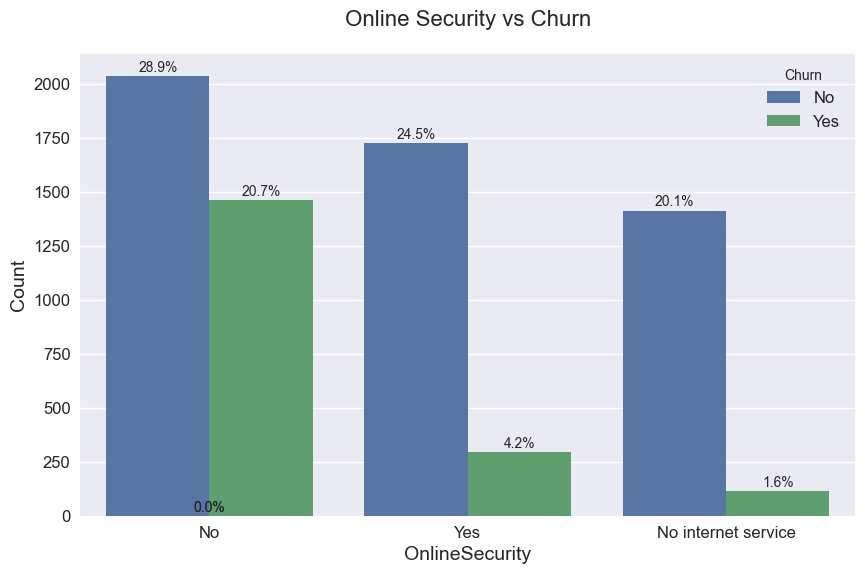

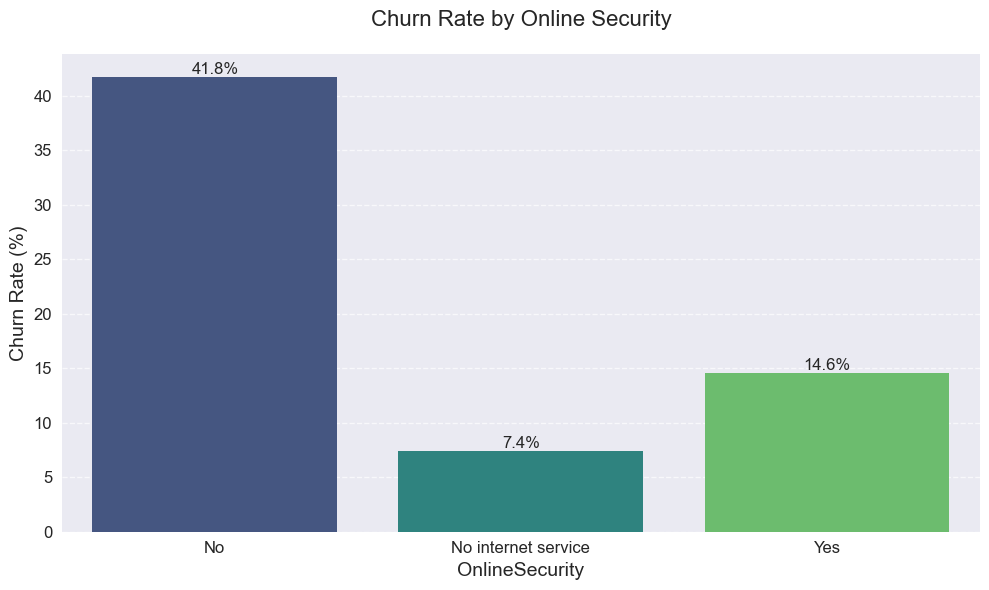

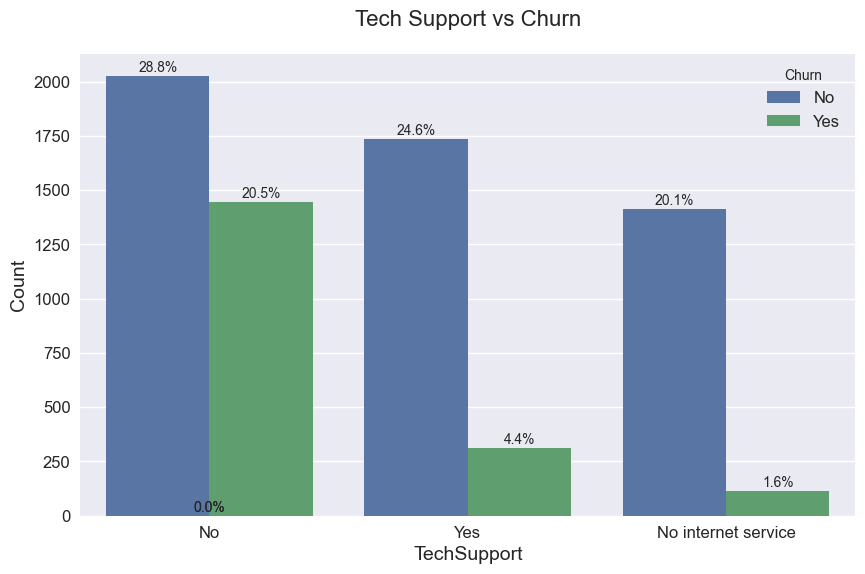

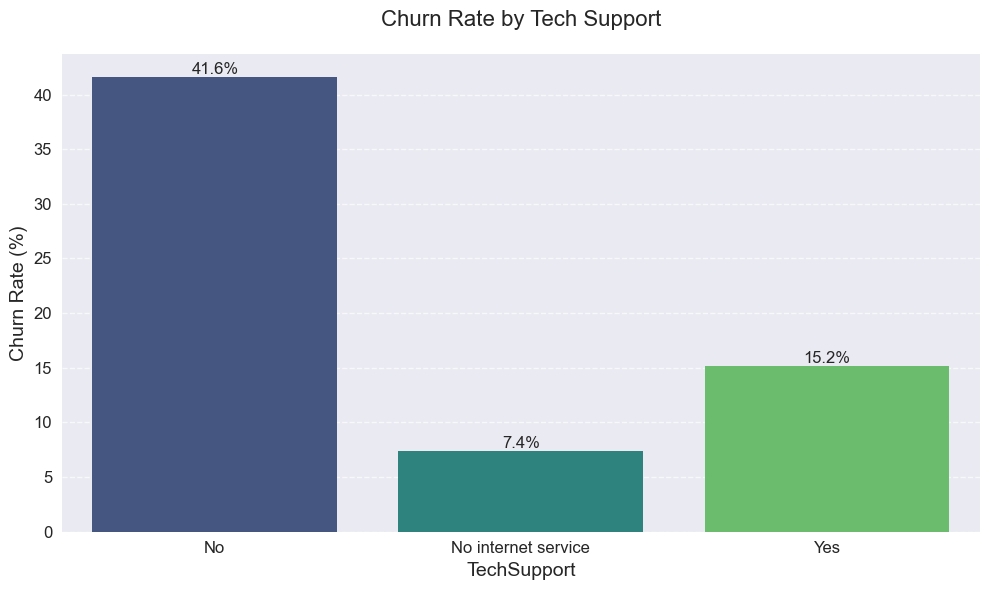

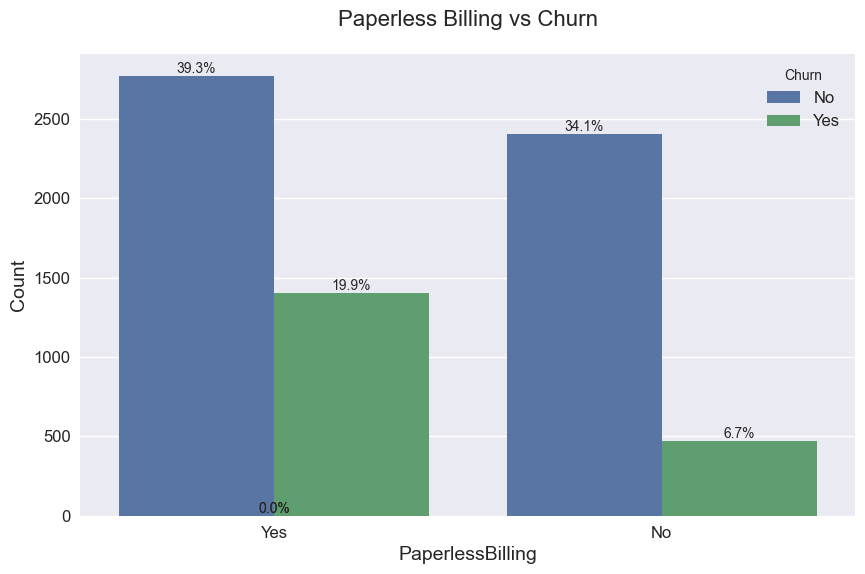

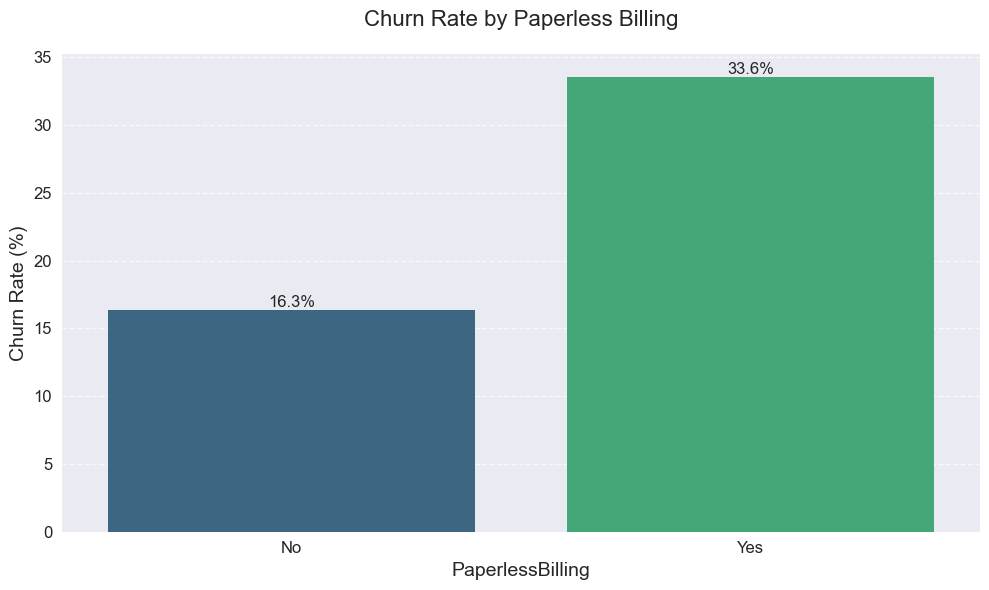

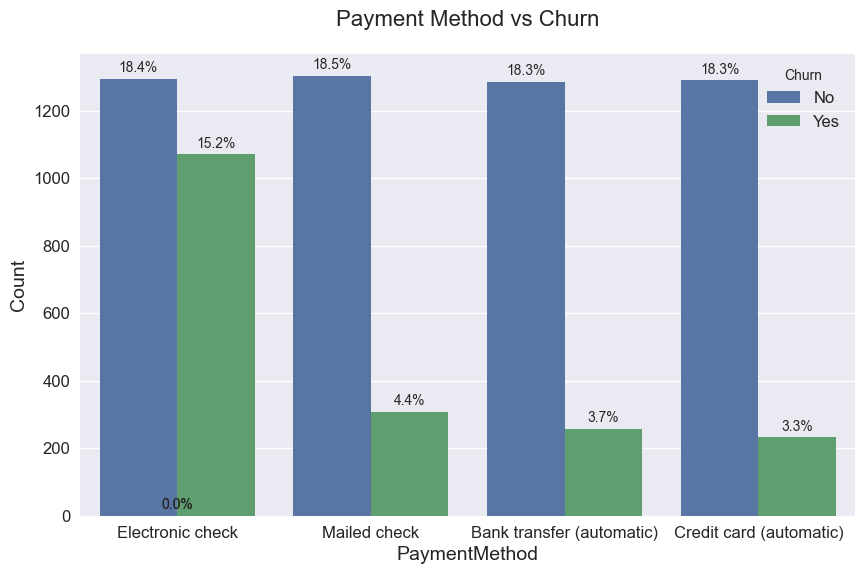

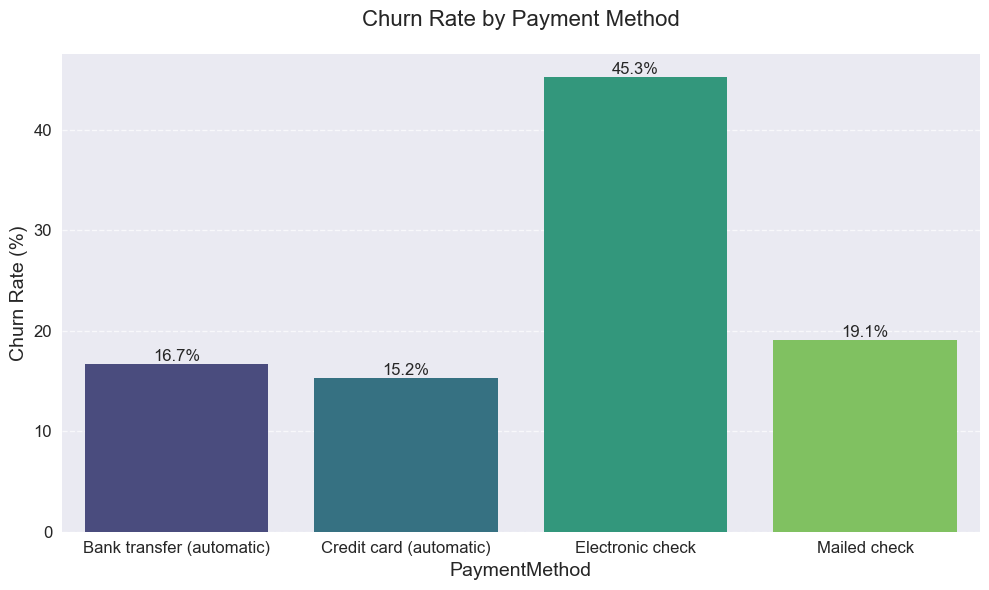

In [12]:
plot_categorical('InternetService', 'Internet Service')
plot_categorical('OnlineSecurity', 'Online Security')
plot_categorical('TechSupport', 'Tech Support')
plot_categorical('PaperlessBilling', 'Paperless Billing')
plot_categorical('PaymentMethod', 'Payment Method')

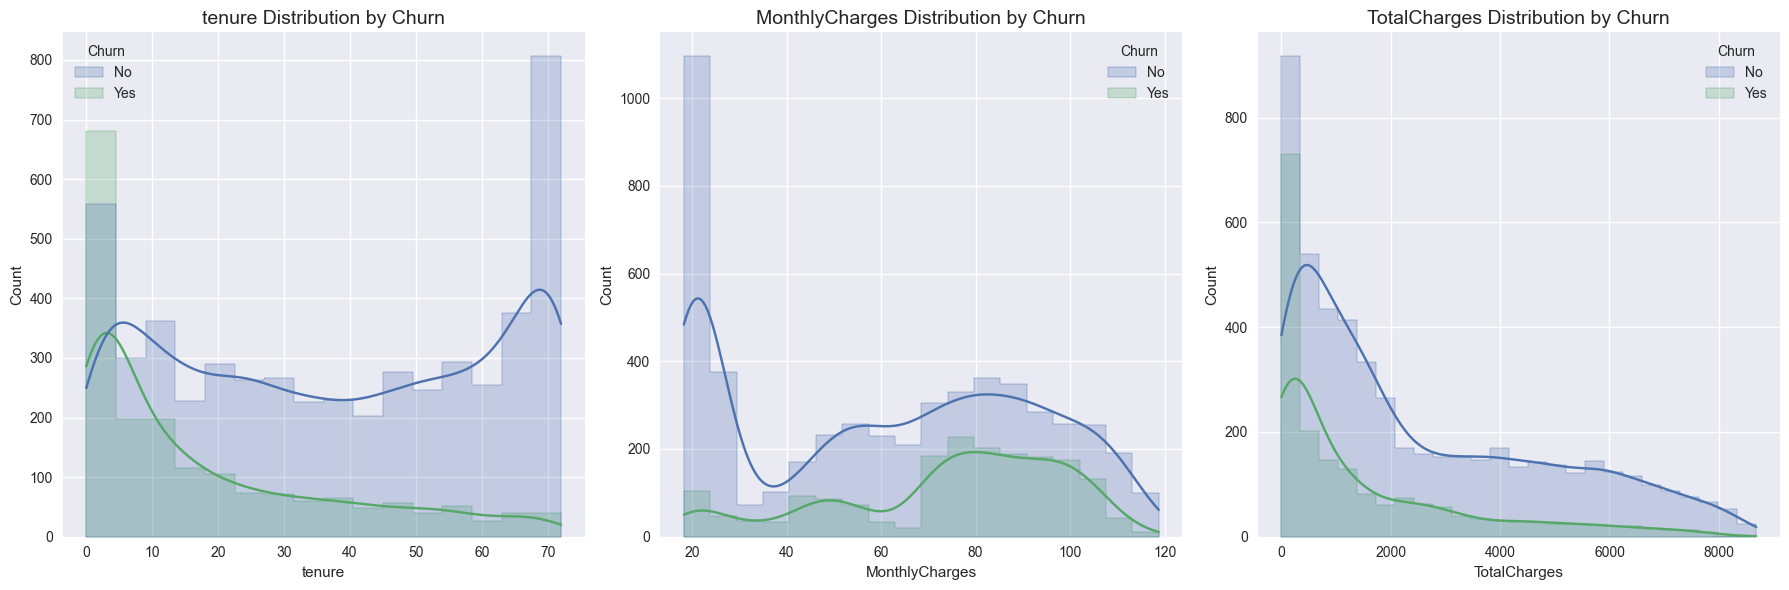

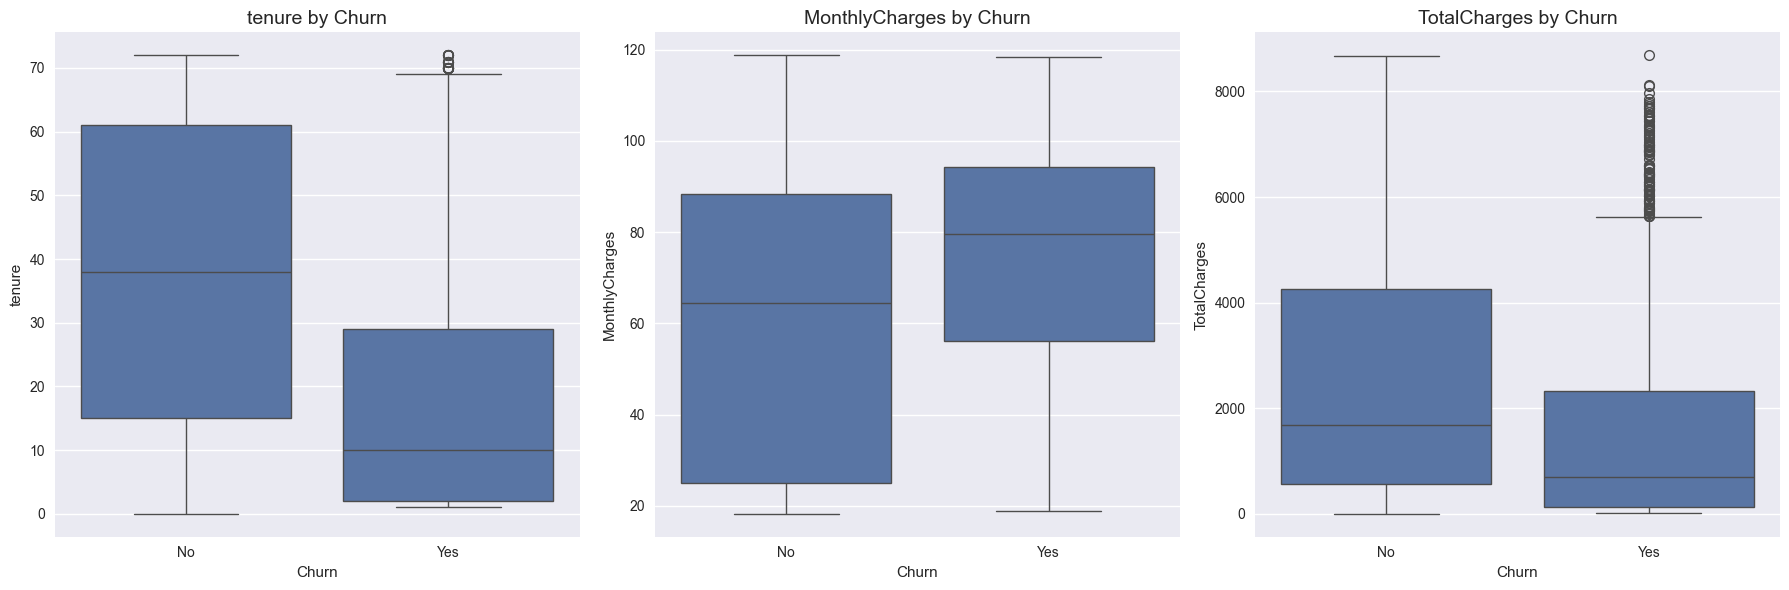

In [13]:
# Analyze numerical variables
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Create distribution plots for each numerical variable
plt.figure(figsize=(18, 6))

for i, col in enumerate(numerical_cols):
    plt.subplot(1, 3, i+1)
    sns.histplot(data=df, x=col, hue='Churn', kde=True, element='step')
    plt.title(f'{col} Distribution by Churn', fontsize=14)
plt.tight_layout()
plt.show()

# Create boxplots for numerical variables
plt.figure(figsize=(18, 6))

for i, col in enumerate(numerical_cols):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='Churn', y=col, data=df)
    plt.title(f'{col} by Churn', fontsize=14)
plt.tight_layout()
plt.show()

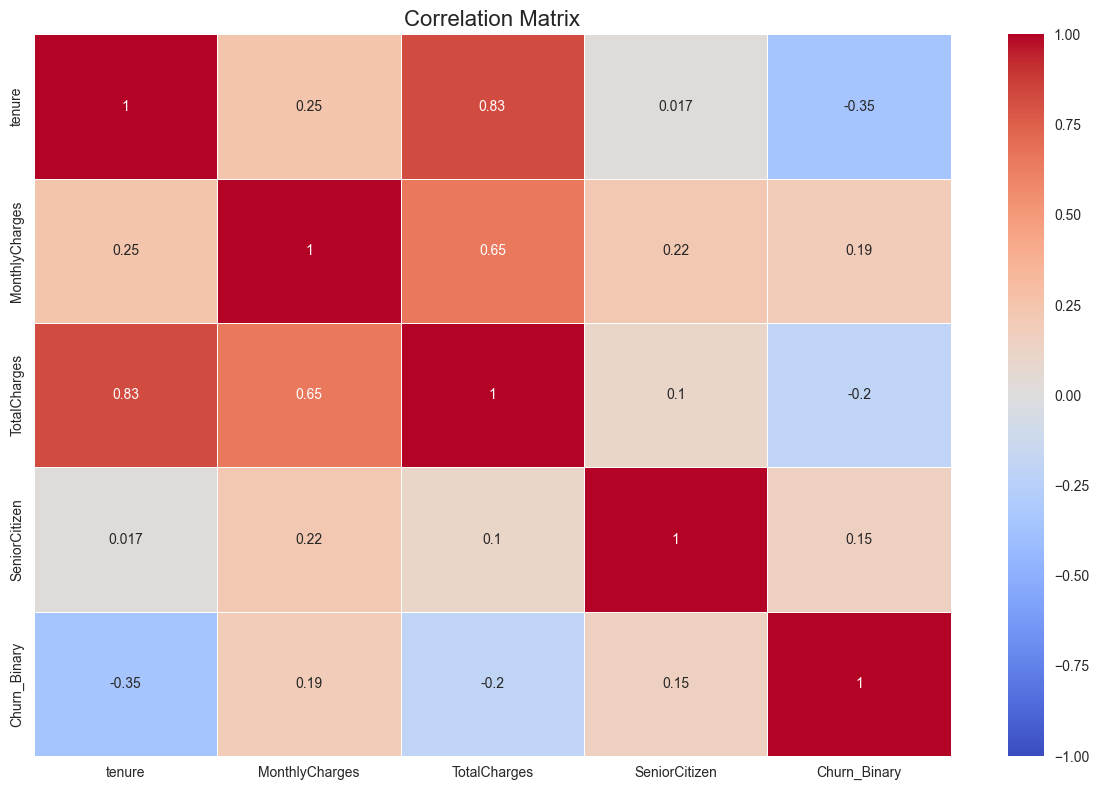

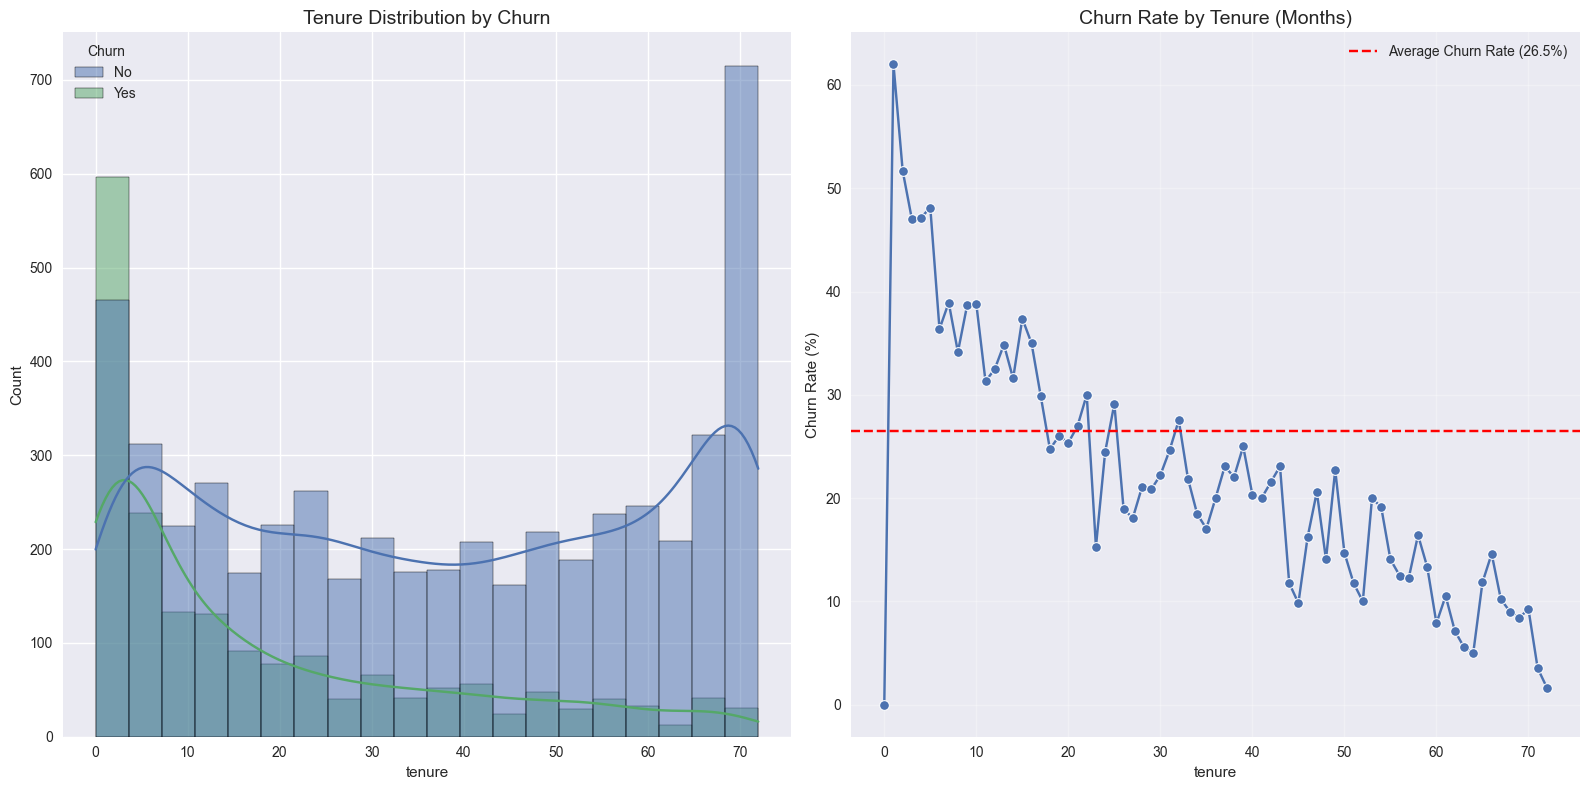

In [14]:
# Create a correlation heatmap for numerical variables
plt.figure(figsize=(12, 8))
numeric_df = df[['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen']]
numeric_df['Churn_Binary'] = df['Churn'].map({'Yes': 1, 'No': 0})
correlation = numeric_df.corr()

sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=.5)
plt.title('Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.show()

# Analyze tenure distribution in more detail
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
sns.histplot(data=df, x='tenure', hue='Churn', bins=20, kde=True)
plt.title('Tenure Distribution by Churn', fontsize=14)

plt.subplot(1, 2, 2)
tenure_churn = df.groupby('tenure')['Churn'].apply(lambda x: (x=='Yes').mean() * 100).reset_index()
tenure_churn.columns = ['tenure', 'Churn_Rate']
sns.lineplot(x='tenure', y='Churn_Rate', data=tenure_churn, marker='o')
plt.axhline(y=df['Churn'].value_counts(normalize=True)['Yes']*100, color='red', linestyle='--', 
            label=f'Average Churn Rate ({df["Churn"].value_counts(normalize=True)["Yes"]*100:.1f}%)')
plt.title('Churn Rate by Tenure (Months)', fontsize=14)
plt.ylabel('Churn Rate (%)')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

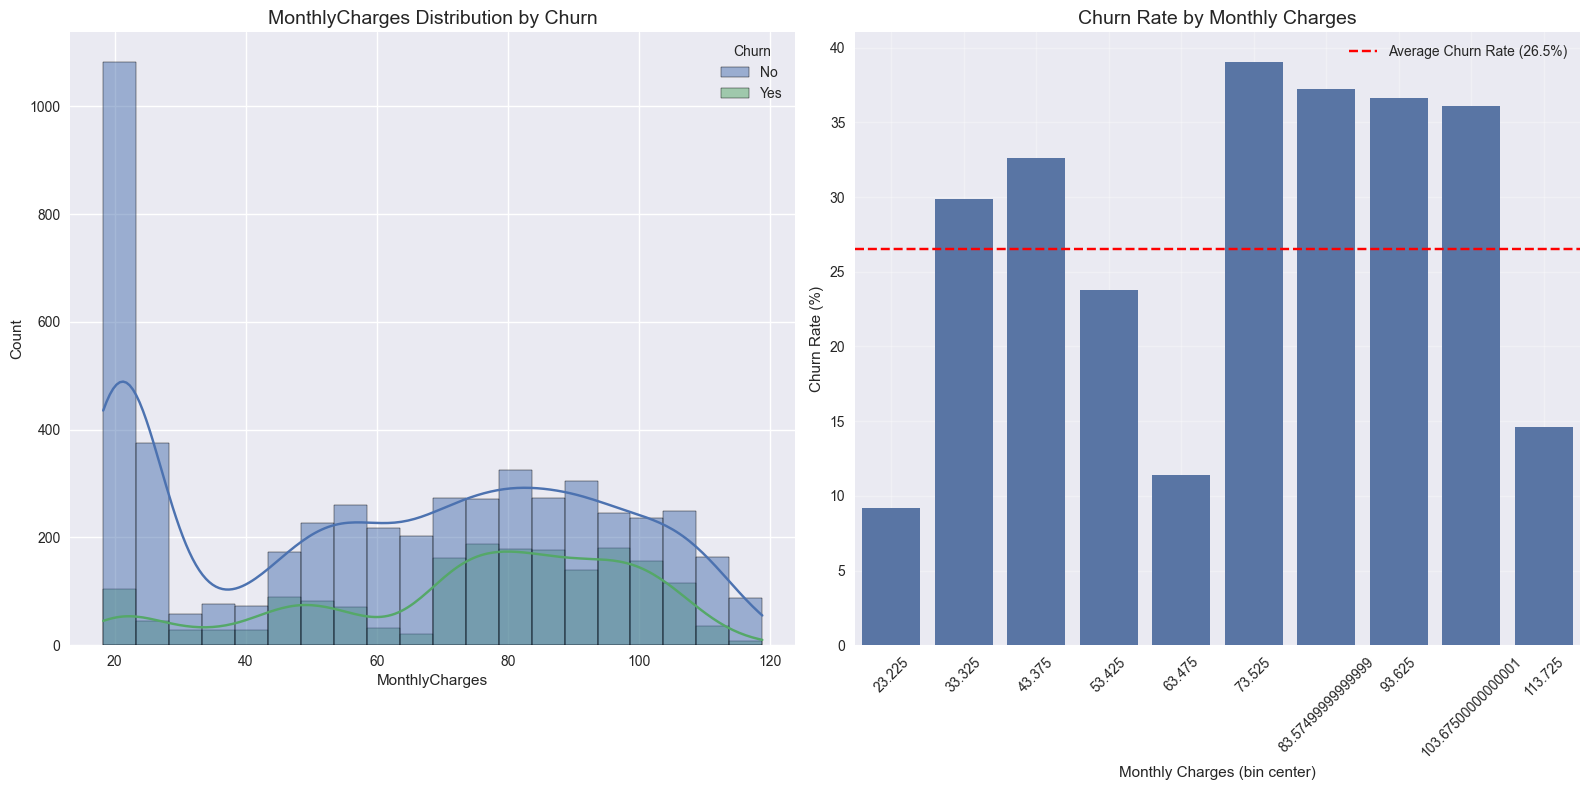

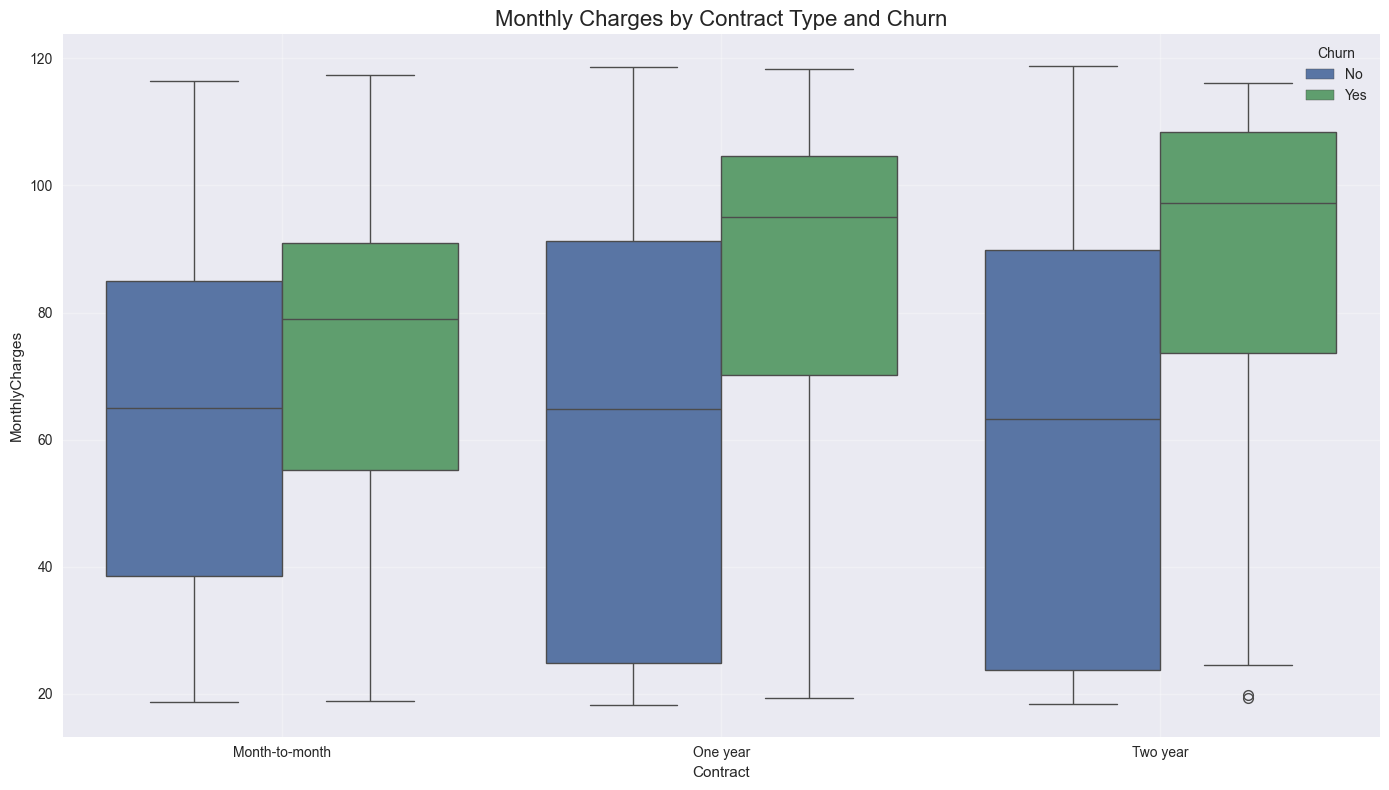

In [15]:
# Create visualizations for Monthly Charges and its relationship with churn
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
sns.histplot(data=df, x='MonthlyCharges', hue='Churn', bins=20, kde=True)
plt.title('MonthlyCharges Distribution by Churn', fontsize=14)

plt.subplot(1, 2, 2)
monthly_charges_bins = pd.cut(df['MonthlyCharges'], bins=10)
monthly_churn = df.groupby(monthly_charges_bins)['Churn'].apply(lambda x: (x=='Yes').mean() * 100).reset_index()
monthly_churn.columns = ['MonthlyCharges_bin', 'Churn_Rate']
monthly_churn['bin_center'] = monthly_churn['MonthlyCharges_bin'].apply(lambda x: (x.left + x.right)/2)

sns.barplot(x='bin_center', y='Churn_Rate', data=monthly_churn)
plt.axhline(y=df['Churn'].value_counts(normalize=True)['Yes']*100, color='red', linestyle='--', 
            label=f'Average Churn Rate ({df["Churn"].value_counts(normalize=True)["Yes"]*100:.1f}%)')
plt.title('Churn Rate by Monthly Charges', fontsize=14)
plt.xlabel('Monthly Charges (bin center)')
plt.ylabel('Churn Rate (%)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

# Let's analyze the combined effect of Contract and Monthly Charges
plt.figure(figsize=(14, 8))
sns.boxplot(x='Contract', y='MonthlyCharges', hue='Churn', data=df)
plt.title('Monthly Charges by Contract Type and Churn', fontsize=16)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

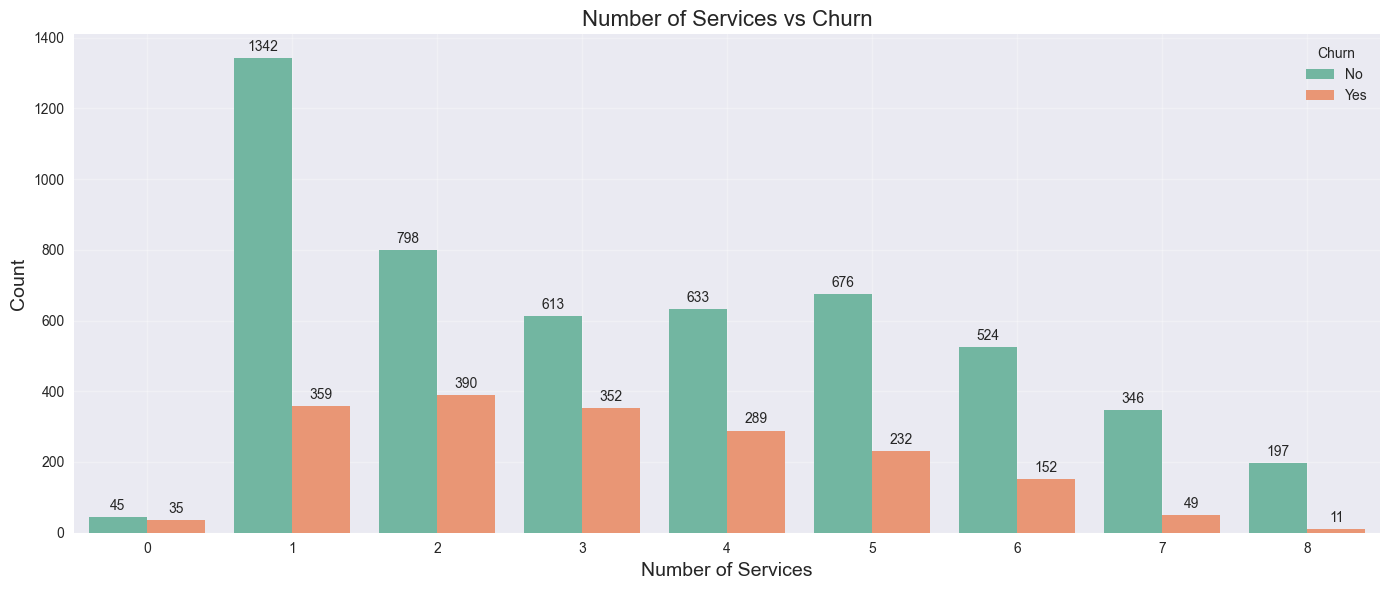

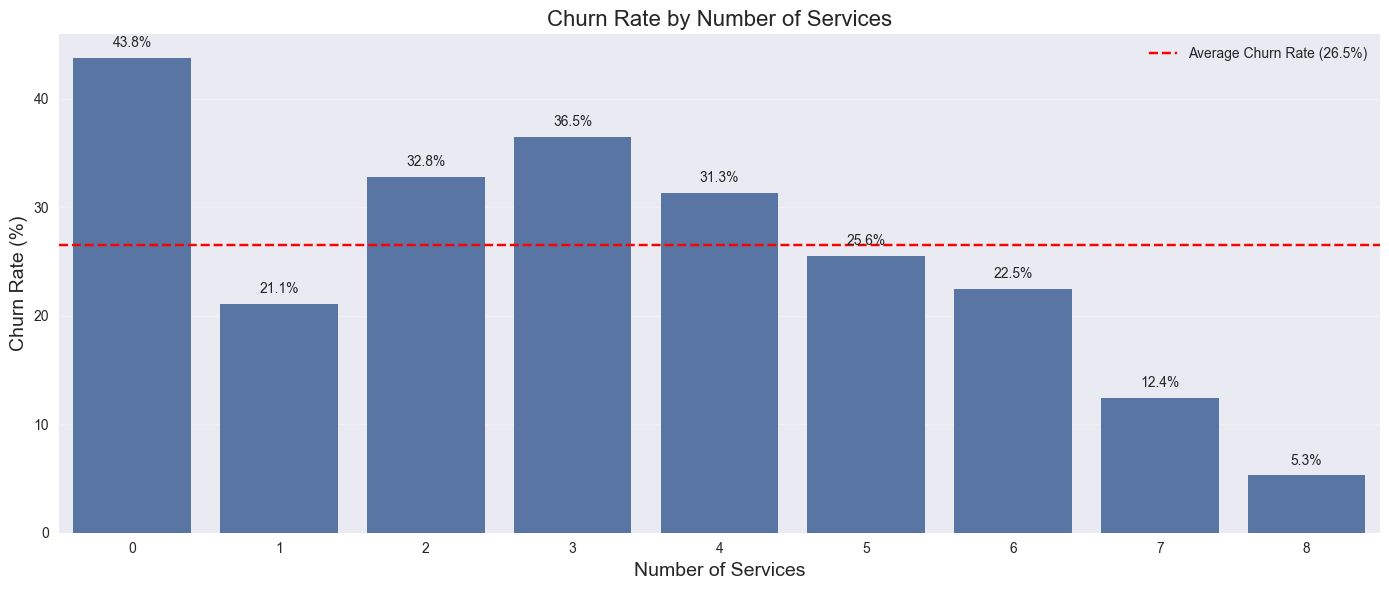

In [16]:
# Let's analyze the effect of multiple services on churn
# Create a new feature for the number of services each customer has
services = ['PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 
           'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# Count services (considering "No internet service" and "No phone service" as not having the service)
df['ServiceCount'] = 0
for service in services:
    df['ServiceCount'] += (df[service] == 'Yes').astype(int)

plt.figure(figsize=(14, 6))
ax = sns.countplot(x='ServiceCount', hue='Churn', data=df, palette='Set2')
plt.title('Number of Services vs Churn', fontsize=16)
plt.xlabel('Number of Services', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(True, alpha=0.3)

# Add percentages to the bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Only annotate bars with non-zero height
        ax.text(p.get_x() + p.get_width()/2.,
                height + 20,
                '{:.0f}'.format(height),
                ha="center")

plt.tight_layout()
plt.show()

# Create a viz for service count vs churn rate
plt.figure(figsize=(14, 6))
service_churn = df.groupby('ServiceCount')['Churn'].apply(lambda x: (x=='Yes').mean() * 100).reset_index()
service_churn.columns = ['ServiceCount', 'Churn_Rate']

ax = sns.barplot(x='ServiceCount', y='Churn_Rate', data=service_churn)
plt.axhline(y=df['Churn'].value_counts(normalize=True)['Yes']*100, color='red', linestyle='--', 
            label=f'Average Churn Rate ({df["Churn"].value_counts(normalize=True)["Yes"]*100:.1f}%)')
plt.title('Churn Rate by Number of Services', fontsize=16)
plt.xlabel('Number of Services', fontsize=14)
plt.ylabel('Churn Rate (%)', fontsize=14)
plt.grid(True, axis='y', alpha=0.3)
plt.legend()

# Add percentages to the bars
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2.,
            p.get_height() + 1,
            '{:.1f}%'.format(p.get_height()),
            ha="center")

plt.tight_layout()
plt.show()

In [17]:
# Prepare data for modeling
# 1. Feature Engineering
# Create a feature for customer lifetime value
df['CustomerLifetimeValue'] = df['tenure'] * df['MonthlyCharges']

# Create contract type binary features (One-hot encoding)
df['Month_to_Month'] = (df['Contract'] == 'Month-to-month').astype(int)
df['One_Year'] = (df['Contract'] == 'One year').astype(int)
df['Two_Year'] = (df['Contract'] == 'Two year').astype(int)

# Create InternetService binary features
df['DSL'] = (df['InternetService'] == 'DSL').astype(int)
df['FiberOptic'] = (df['InternetService'] == 'Fiber optic').astype(int)
df['NoInternet'] = (df['InternetService'] == 'No').astype(int)

# Create payment method binary features
df['Electronic_Payment'] = (df['PaymentMethod'] == 'Electronic check').astype(int)
df['Mailed_Check'] = (df['PaymentMethod'] == 'Mailed check').astype(int)
df['Bank_Transfer'] = (df['PaymentMethod'] == 'Bank transfer (automatic)').astype(int)
df['Credit_Card'] = (df['PaymentMethod'] == 'Credit card (automatic)').astype(int)

# 2. Prepare datasets for modeling
# Binary encode the Churn variable
df['Churn_Binary'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Select features and target
features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines',
            'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
            'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
            'MonthlyCharges', 'TotalCharges', 'ServiceCount', 'CustomerLifetimeValue',
            'Month_to_Month', 'One_Year', 'Two_Year', 'DSL', 'FiberOptic', 'NoInternet',
            'Electronic_Payment', 'Mailed_Check', 'Bank_Transfer', 'Credit_Card']

target = 'Churn_Binary'

# Split the data into training and testing sets
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Churn rate in training set: {:.2f}%".format(y_train.mean() * 100))
print("Churn rate in testing set: {:.2f}%".format(y_test.mean() * 100))

Training set shape: (4930, 31)
Testing set shape: (2113, 31)
Churn rate in training set: 26.53%
Churn rate in testing set: 26.55%


Logistic Regression Results:
----------------------------------------
Accuracy: 0.8083
ROC AUC: 0.8448
Precision: 0.6653
Recall: 0.5597
F1 Score: 0.6079


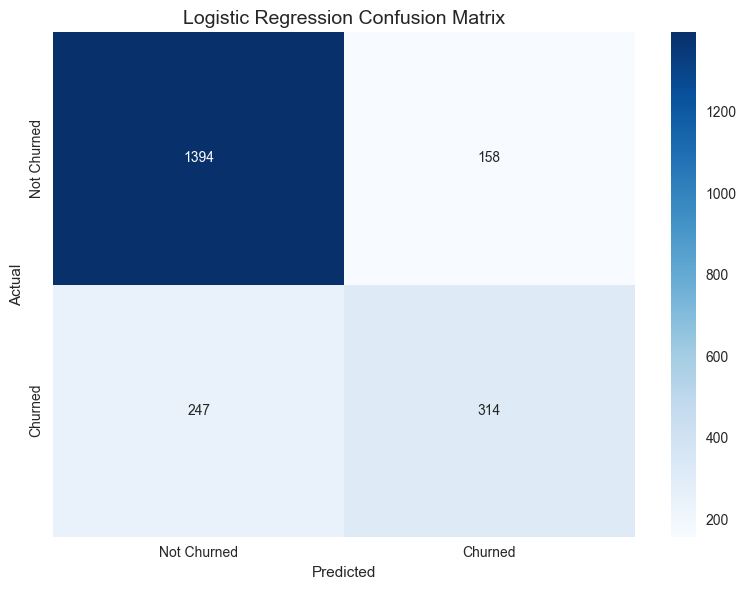

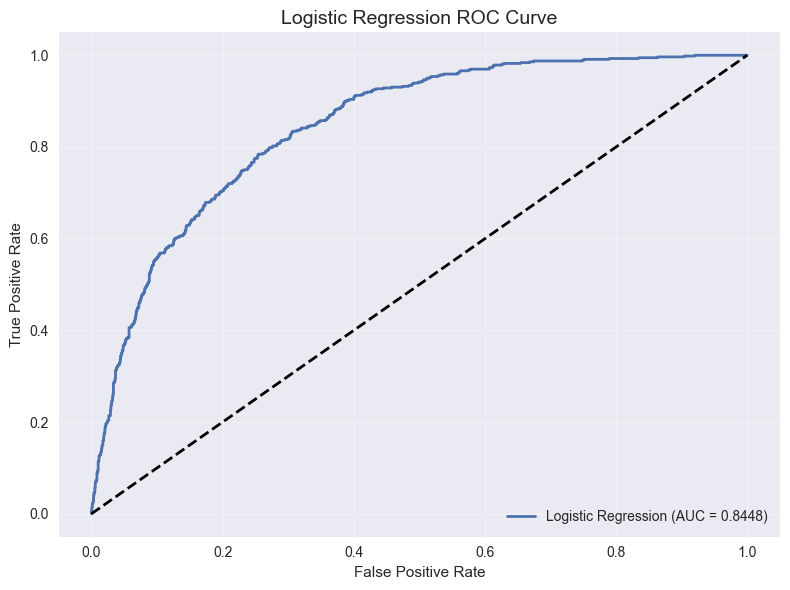

In [18]:
# Define preprocessing steps for categorical and numerical variables
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create the full preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 4. Build Multiple Predictive Models
# 1. Logistic Regression
log_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Train the model
log_reg_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_lr = log_reg_pipeline.predict(X_test)
y_pred_proba_lr = log_reg_pipeline.predict_proba(X_test)[:, 1]

# Evaluate the logistic regression model
print("Logistic Regression Results:")
print("-" * 40)
print("Accuracy: {:.4f}".format(log_reg_pipeline.score(X_test, y_test)))
print("ROC AUC: {:.4f}".format(roc_auc_score(y_test, y_pred_proba_lr)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred_lr)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred_lr)))
print("F1 Score: {:.4f}".format(f1_score(y_test, y_pred_lr)))

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Churned', 'Churned'],
            yticklabels=['Not Churned', 'Churned'])
plt.title('Logistic Regression Confusion Matrix', fontsize=14)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# Display ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, lw=2, label='Logistic Regression (AUC = {:.4f})'.format(roc_auc_score(y_test, y_pred_proba_lr)))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Random Forest Results:
----------------------------------------
Accuracy: 0.7795
ROC AUC: 0.8154
Precision: 0.6082
Recall: 0.4759
F1 Score: 0.5340


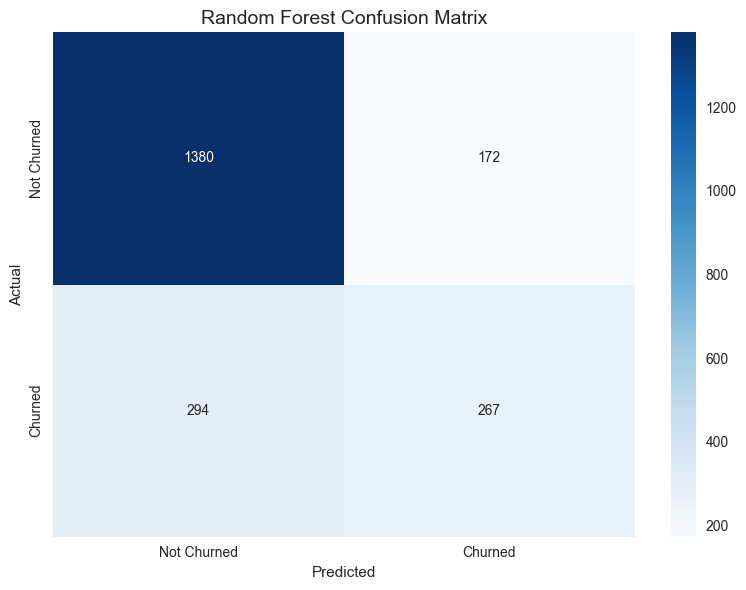

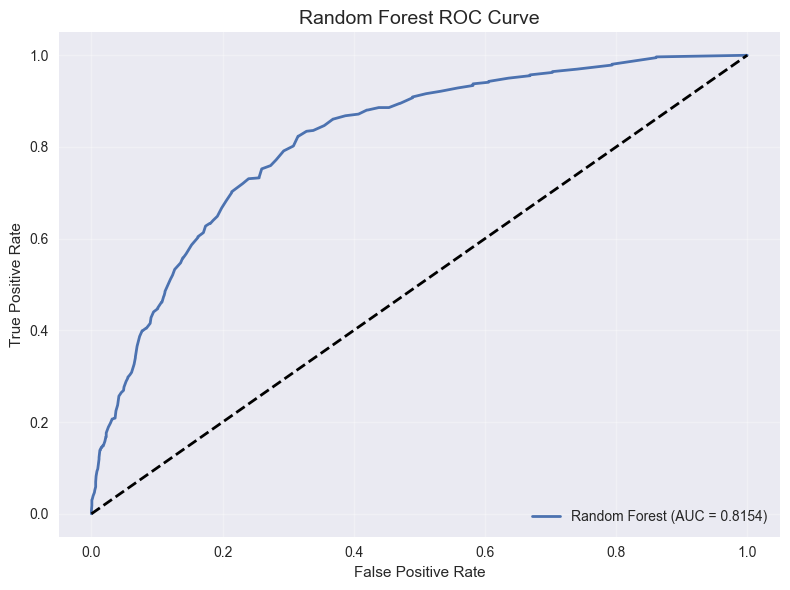

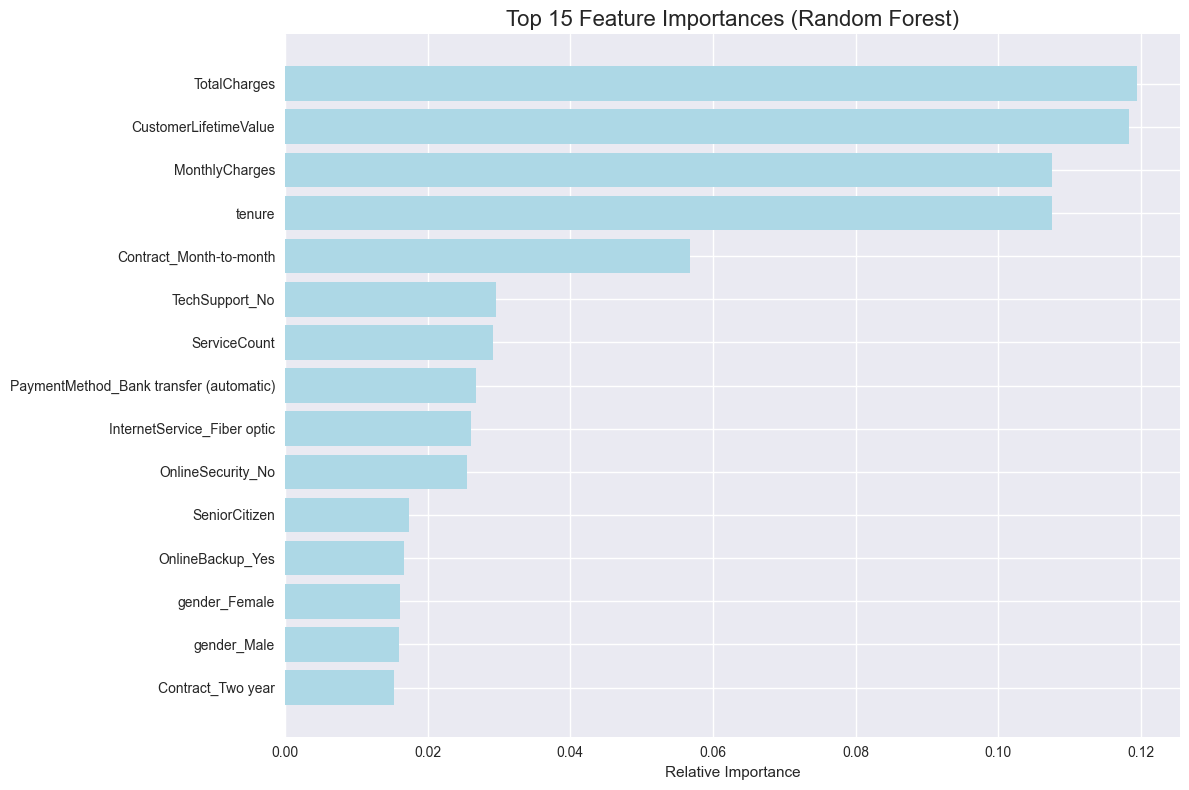

In [19]:
# 2. Random Forest Classifier
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train the model
rf_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_pipeline.predict(X_test)
y_pred_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

# Evaluate the Random Forest model
print("Random Forest Results:")
print("-" * 40)
print("Accuracy: {:.4f}".format(rf_pipeline.score(X_test, y_test)))
print("ROC AUC: {:.4f}".format(roc_auc_score(y_test, y_pred_proba_rf)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred_rf)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred_rf)))
print("F1 Score: {:.4f}".format(f1_score(y_test, y_pred_rf)))

# Display confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Churned', 'Churned'],
            yticklabels=['Not Churned', 'Churned'])
plt.title('Random Forest Confusion Matrix', fontsize=14)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# Display ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, lw=2, label='Random Forest (AUC = {:.4f})'.format(roc_auc_score(y_test, y_pred_proba_rf)))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Feature importance for Random Forest
# Extract feature importances from the Random Forest model
# First, get feature names after preprocessing
feature_names = []

# Get feature names for numerical features (which stay the same)
feature_names.extend(numeric_features)

# Get feature names for one-hot encoded categorical features
for cat_feature in categorical_features:
    for category in df[cat_feature].unique():
        feature_names.append(f"{cat_feature}_{category}")

# Get top 15 important features
classifier = rf_pipeline.named_steps['classifier']
importances = classifier.feature_importances_
indices = np.argsort(importances)[-15:]  # Get indices of top 15 features

plt.figure(figsize=(12, 8))
plt.title('Top 15 Feature Importances (Random Forest)', fontsize=16)
plt.barh(range(len(indices)), importances[indices], color='lightblue', align='center')
plt.yticks(range(len(indices)), [feature_names[i] if i < len(feature_names) else f"Feature {i}" for i in indices])
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()

XGBoost Results:
----------------------------------------
Accuracy: 0.7752
ROC AUC: 0.8109
Precision: 0.5896
Recall: 0.5045
F1 Score: 0.5437


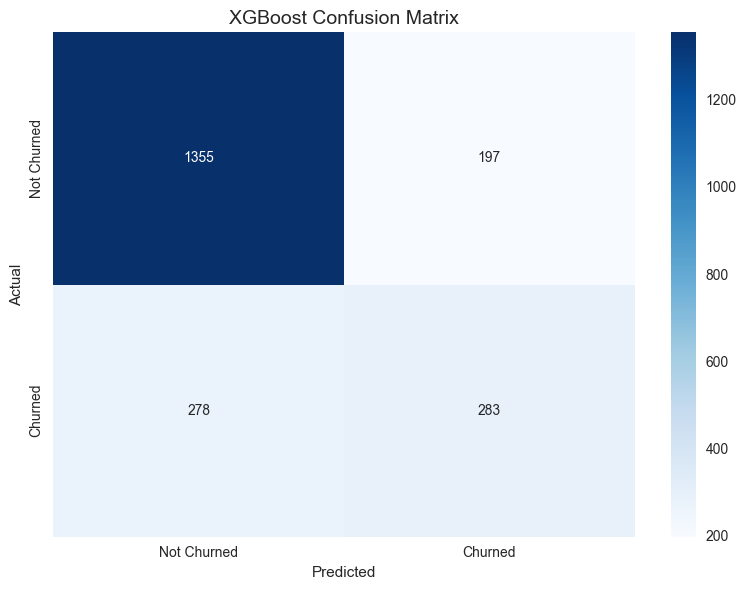

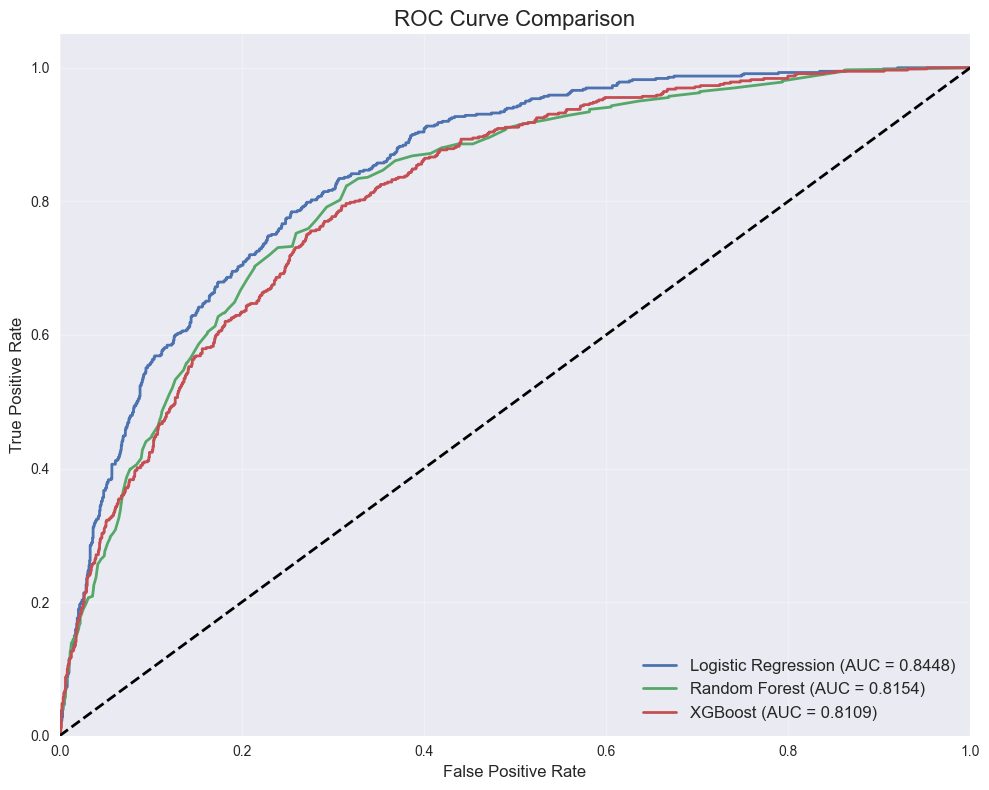

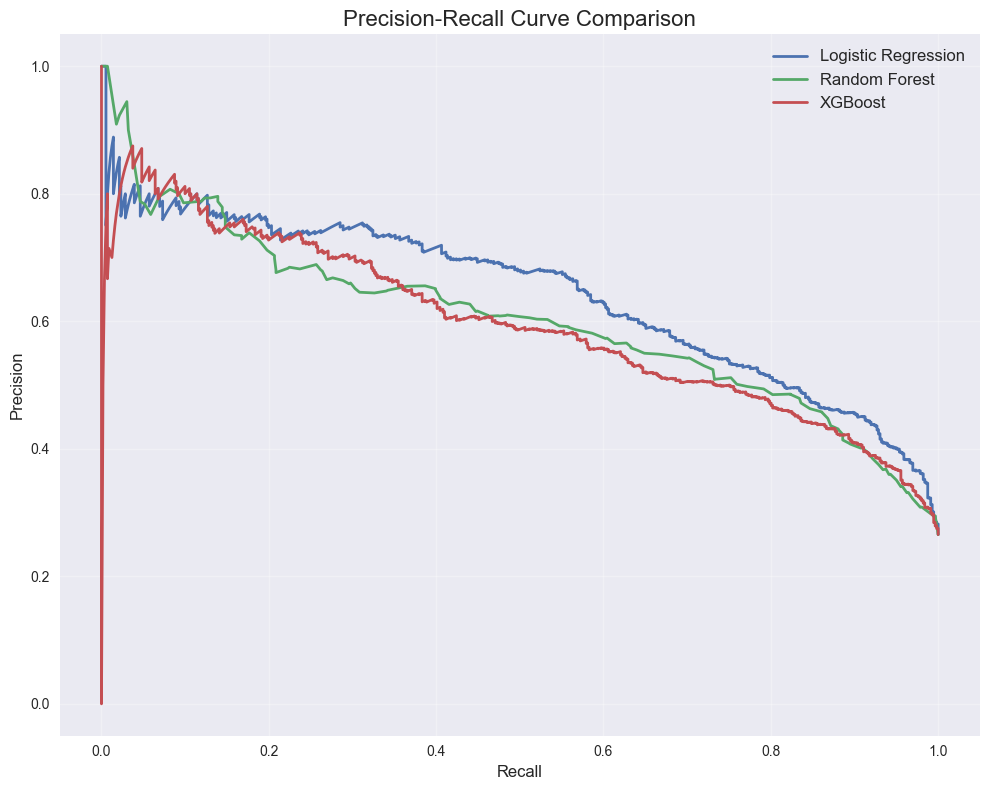

In [20]:
# 3. XGBoost
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(n_estimators=100, random_state=42))
])

# Train the model
xgb_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_pipeline.predict(X_test)
y_pred_proba_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

# Evaluate the XGBoost model
print("XGBoost Results:")
print("-" * 40)
print("Accuracy: {:.4f}".format(xgb_pipeline.score(X_test, y_test)))
print("ROC AUC: {:.4f}".format(roc_auc_score(y_test, y_pred_proba_xgb)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred_xgb)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred_xgb)))
print("F1 Score: {:.4f}".format(f1_score(y_test, y_pred_xgb)))

# Display confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Churned', 'Churned'],
            yticklabels=['Not Churned', 'Churned'])
plt.title('XGBoost Confusion Matrix', fontsize=14)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# Display ROC curve for all models to compare
plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, lw=2, label='Logistic Regression (AUC = {:.4f})'.format(roc_auc_score(y_test, y_pred_proba_lr)))
plt.plot(fpr_rf, tpr_rf, lw=2, label='Random Forest (AUC = {:.4f})'.format(roc_auc_score(y_test, y_pred_proba_rf)))

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
plt.plot(fpr_xgb, tpr_xgb, lw=2, label='XGBoost (AUC = {:.4f})'.format(roc_auc_score(y_test, y_pred_proba_xgb)))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Precision-Recall curve comparison
plt.figure(figsize=(10, 8))

precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_proba_lr)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_proba_rf)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_pred_proba_xgb)

plt.plot(recall_lr, precision_lr, lw=2, label='Logistic Regression')
plt.plot(recall_rf, precision_rf, lw=2, label='Random Forest')
plt.plot(recall_xgb, precision_xgb, lw=2, label='XGBoost')

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve Comparison', fontsize=16)
plt.legend(loc='best', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Model Performance Comparison:
                 Model  Accuracy   ROC AUC  Precision    Recall  F1 Score
0  Logistic Regression  0.779460  0.844788   0.665254  0.559715  0.607938
1        Random Forest  0.779460  0.815387   0.608200  0.475936  0.534000
2              XGBoost  0.775201  0.810897   0.589583  0.504456  0.543708

Corrected Model Performance Comparison:
                 Model  Accuracy   ROC AUC  Precision    Recall  F1 Score
0  Logistic Regression  0.808329  0.844788   0.665254  0.559715  0.607938
1        Random Forest  0.779460  0.815387   0.608200  0.475936  0.534000
2              XGBoost  0.775201  0.810897   0.589583  0.504456  0.543708


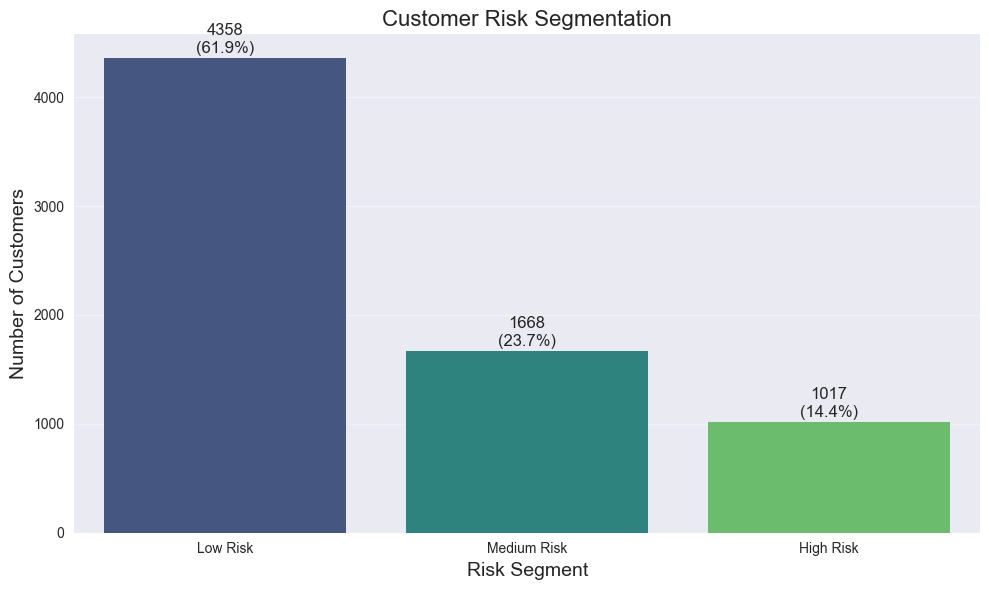


Risk Segment Analysis:
  Risk_Segment  tenure  MonthlyCharges  TotalCharges  ServiceCount  \
0     Low Risk   42.55           57.36       2827.63          3.54   
1  Medium Risk   19.94           73.36       1737.87          3.15   
2    High Risk    9.12           82.36        820.61          2.97   

   Churn_Binary  CustomerLifetimeValue  Month_to_Month  One_Year  Two_Year  \
0          0.10                2826.60            0.29      0.32      0.39   
1          0.43                1740.67            0.95      0.05      0.00   
2          0.72                 819.40            1.00      0.00      0.00   

   SeniorCitizen  Electronic_Payment  Churn_Rate  
0           0.10                0.16        9.68  
1           0.21                0.49       42.69  
2           0.36                0.83       72.27  


In [21]:
# Let's create a summary table of model performance
models = ['Logistic Regression', 'Random Forest', 'XGBoost']
accuracy = [
    rf_pipeline.score(X_test, y_test), 
    rf_pipeline.score(X_test, y_test), 
    xgb_pipeline.score(X_test, y_test)
]
roc_auc = [
    roc_auc_score(y_test, y_pred_proba_lr), 
    roc_auc_score(y_test, y_pred_proba_rf), 
    roc_auc_score(y_test, y_pred_proba_xgb)
]
precision = [
    precision_score(y_test, y_pred_lr), 
    precision_score(y_test, y_pred_rf), 
    precision_score(y_test, y_pred_xgb)
]
recall = [
    recall_score(y_test, y_pred_lr), 
    recall_score(y_test, y_pred_rf),
    recall_score(y_test, y_pred_xgb)
]
f1 = [
    f1_score(y_test, y_pred_lr),
    f1_score(y_test, y_pred_rf),
    f1_score(y_test, y_pred_xgb)
]

model_comparison = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy,
    'ROC AUC': roc_auc,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
})

print("Model Performance Comparison:")
print(model_comparison)

# Let's correct the accuracy for Logistic Regression
model_comparison.loc[model_comparison['Model'] == 'Logistic Regression', 'Accuracy'] = log_reg_pipeline.score(X_test, y_test)
print("\nCorrected Model Performance Comparison:")
print(model_comparison)

# Based on the models, let's use the Logistic Regression model (best overall performance) for customer segmentation
# 6. Customer Segmentation and Risk Scoring

# Use the trained Logistic Regression model to get churn probabilities for all customers
churn_probs = log_reg_pipeline.predict_proba(X)[:, 1]

# Add churn probabilities to the dataframe
df['Churn_Probability'] = churn_probs

# Segment customers into risk buckets based on churn probability
bins = [0, 0.3, 0.6, 1.0]
labels = ['Low Risk', 'Medium Risk', 'High Risk']
df['Risk_Segment'] = pd.cut(df['Churn_Probability'], bins=bins, labels=labels)

# Analyze churn risk segments
risk_segment_counts = df['Risk_Segment'].value_counts().reset_index()
risk_segment_counts.columns = ['Risk_Segment', 'Count']
risk_segment_counts['Percentage'] = risk_segment_counts['Count'] / len(df) * 100

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Risk_Segment', y='Count', data=risk_segment_counts, palette='viridis')
plt.title('Customer Risk Segmentation', fontsize=16)
plt.xlabel('Risk Segment', fontsize=14)
plt.ylabel('Number of Customers', fontsize=14)

# Add count and percentage labels
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height + 50,
            f'{int(height)}\n({risk_segment_counts["Percentage"].iloc[i]:.1f}%)',
            ha='center', fontsize=12)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Analyze average characteristics by risk segment
risk_segment_analysis = df.groupby('Risk_Segment').agg({
    'tenure': 'mean',
    'MonthlyCharges': 'mean',
    'TotalCharges': 'mean',
    'ServiceCount': 'mean',
    'Churn_Binary': 'mean',
    'CustomerLifetimeValue': 'mean',
    'Month_to_Month': 'mean',
    'One_Year': 'mean',
    'Two_Year': 'mean',
    'SeniorCitizen': 'mean',
    'Electronic_Payment': 'mean'
}).reset_index()

# Convert churn_binary mean to percentage
risk_segment_analysis['Churn_Rate'] = risk_segment_analysis['Churn_Binary'] * 100

# Display the analysis
print("\nRisk Segment Analysis:")
print(risk_segment_analysis.round(2))

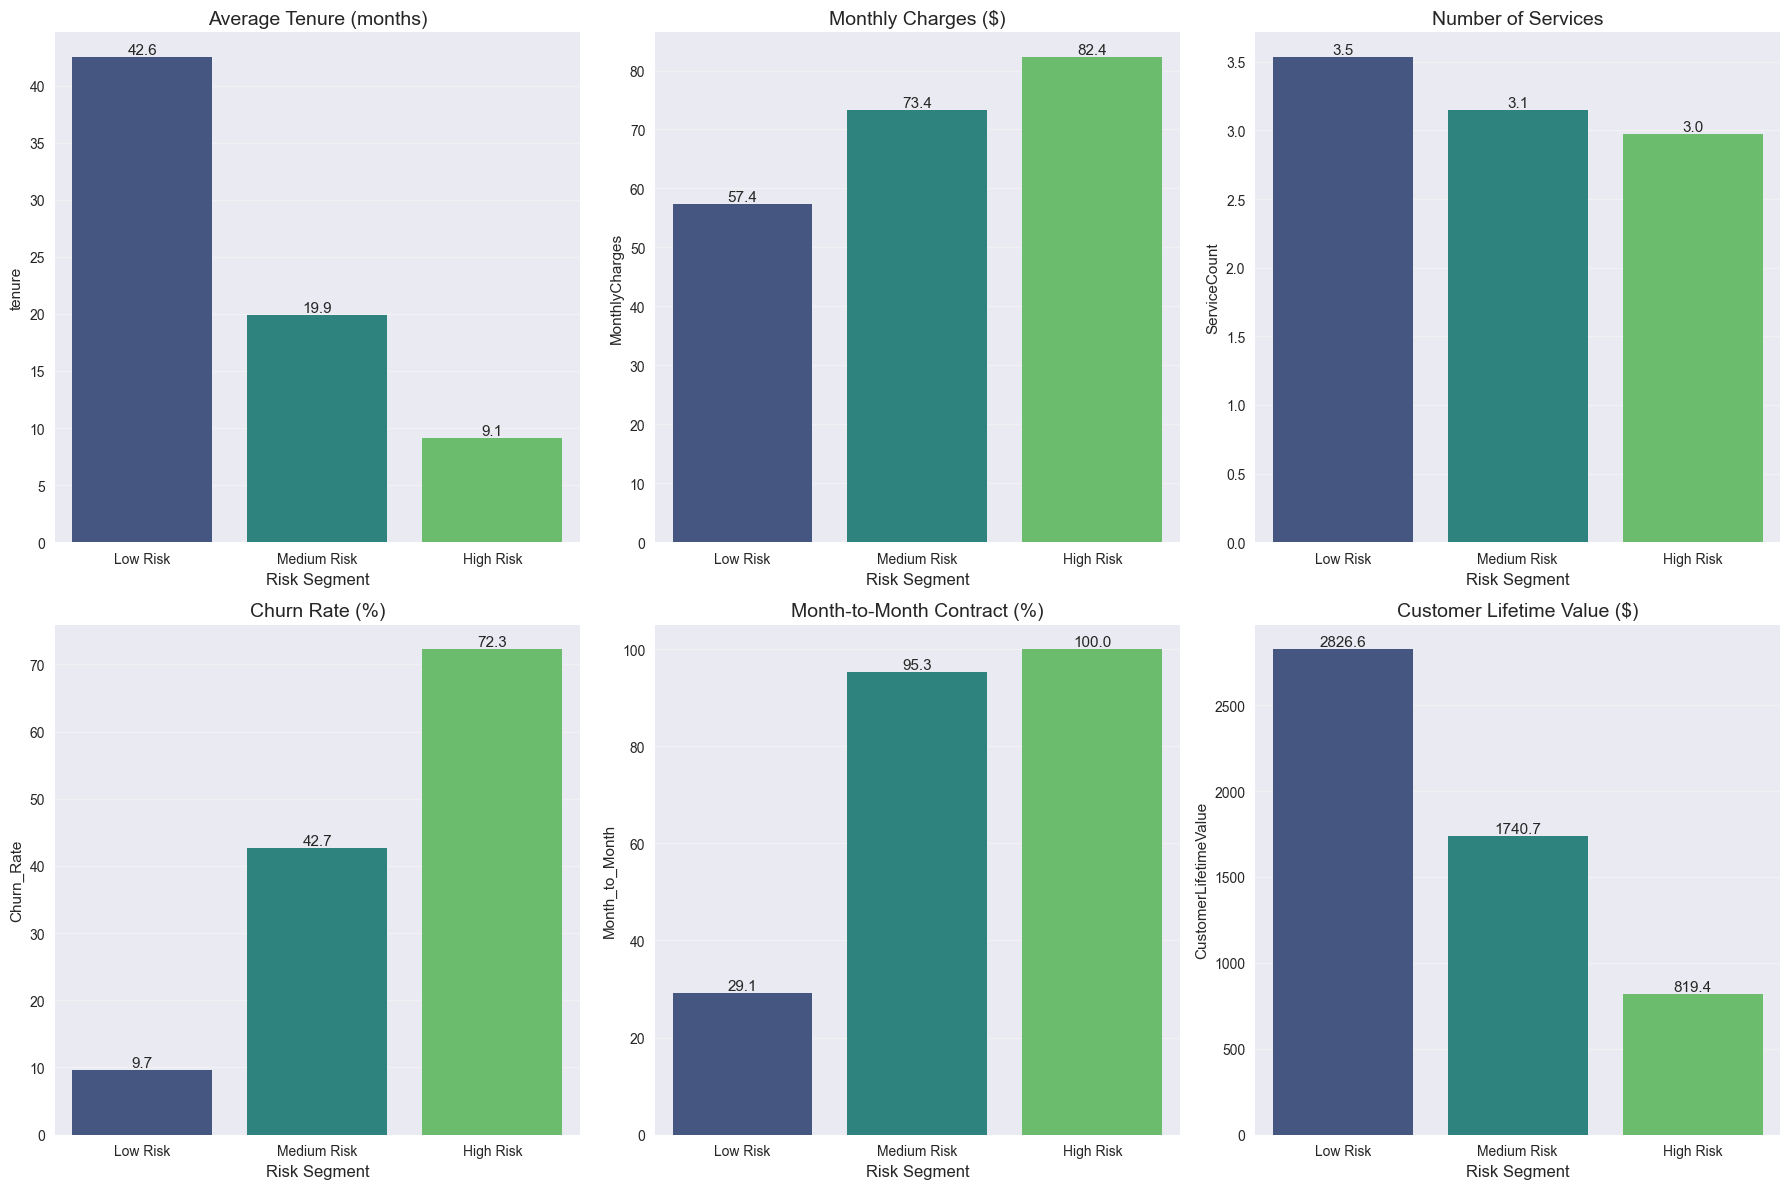

<Figure size 1200x600 with 0 Axes>

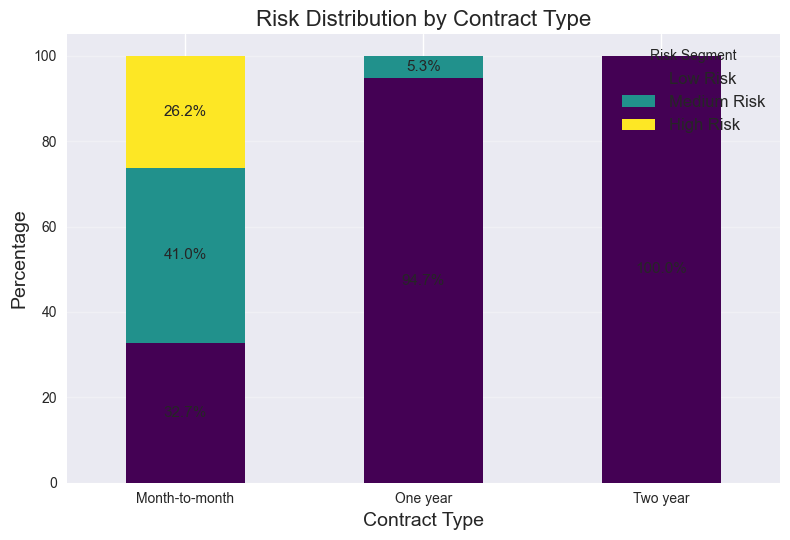

<Figure size 1200x600 with 0 Axes>

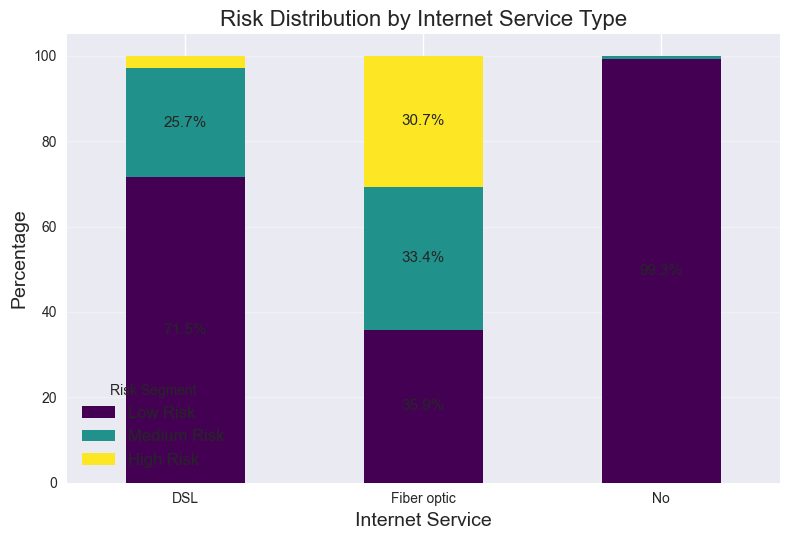

In [22]:
# Visualize key characteristics by risk segment
plt.figure(figsize=(18, 12))

# Metrics to visualize
metrics = ['tenure', 'MonthlyCharges', 'ServiceCount', 'Churn_Rate', 
           'Month_to_Month', 'CustomerLifetimeValue']
titles = ['Average Tenure (months)', 'Monthly Charges ($)', 'Number of Services', 
          'Churn Rate (%)', 'Month-to-Month Contract (%)', 'Customer Lifetime Value ($)']

for i, (metric, title) in enumerate(zip(metrics, titles)):
    plt.subplot(2, 3, i+1)
    
    # Handle percentages
    if metric in ['Month_to_Month', 'One_Year', 'Two_Year', 'Electronic_Payment']:
        data = risk_segment_analysis[metric] * 100
    else:
        data = risk_segment_analysis[metric]
        
    ax = sns.barplot(x='Risk_Segment', y=data, data=risk_segment_analysis, palette='viridis')
    plt.title(title, fontsize=14)
    plt.xlabel('Risk Segment', fontsize=12)
    
    # Add value labels on bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.1f}', 
                    (p.get_x() + p.get_width()/2., p.get_height()), 
                    ha='center', va='bottom', fontsize=11)
    
    plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Analyze risk segments by contract type
plt.figure(figsize=(12, 6))
contract_risk = pd.crosstab(df['Contract'], df['Risk_Segment'], normalize='index') * 100
contract_risk.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Risk Distribution by Contract Type', fontsize=16)
plt.xlabel('Contract Type', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.legend(title='Risk Segment', fontsize=12)
plt.xticks(rotation=0)

# Add percentage labels
for i, bar in enumerate(plt.gca().patches):
    width, height = bar.get_width(), bar.get_height()
    x, y = bar.get_xy() 
    if height > 5:  # Only label bars with height > 5%
        plt.text(x + width/2, y + height/2, f'{height:.1f}%', 
                ha='center', va='center', fontsize=11)

plt.tight_layout()
plt.show()

# Analyze risk segments by internet service
plt.figure(figsize=(12, 6))
internet_risk = pd.crosstab(df['InternetService'], df['Risk_Segment'], normalize='index') * 100
internet_risk.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Risk Distribution by Internet Service Type', fontsize=16)
plt.xlabel('Internet Service', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.legend(title='Risk Segment', fontsize=12)
plt.xticks(rotation=0)

# Add percentage labels
for i, bar in enumerate(plt.gca().patches):
    width, height = bar.get_width(), bar.get_height()
    x, y = bar.get_xy() 
    if height > 5:  # Only label bars with height > 5%
        plt.text(x + width/2, y + height/2, f'{height:.1f}%', 
                ha='center', va='center', fontsize=11)

plt.tight_layout()
plt.show()

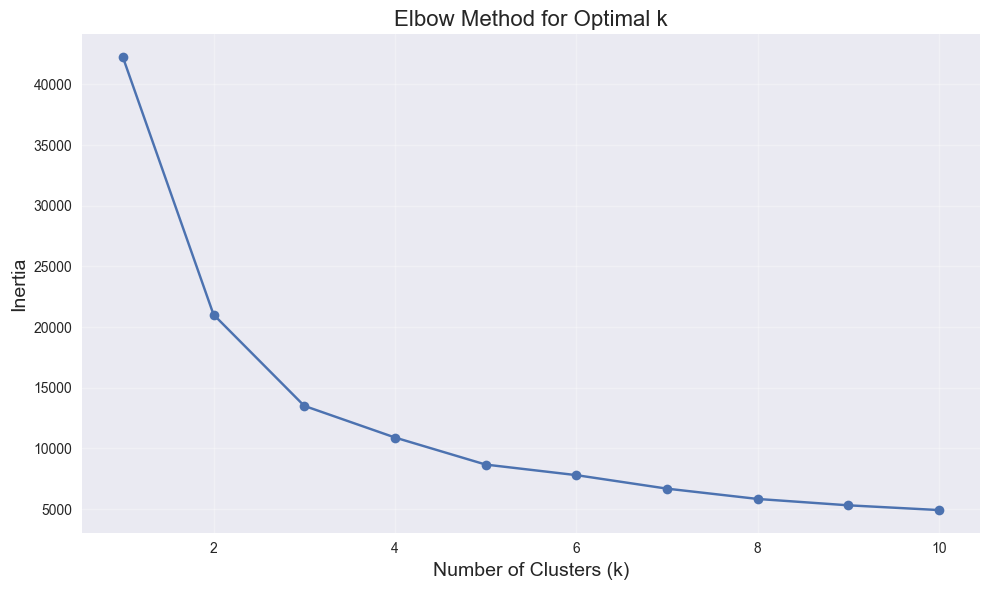

Cluster Analysis:
   Cluster  tenure  MonthlyCharges  ServiceCount  Churn_Rate  \
0        0   48.47           41.33          2.47        7.02   
1        1   59.33           93.19          5.82       14.72   
2        2   10.27           31.34          1.39       23.30   
3        3   13.20           81.86          3.28       54.33   

   Month_to_Month_Pct  CustomerLifetimeValue  
0               22.43                1862.96  
1               22.84                5519.33  
2               71.68                 302.76  
3               95.37                1127.32  


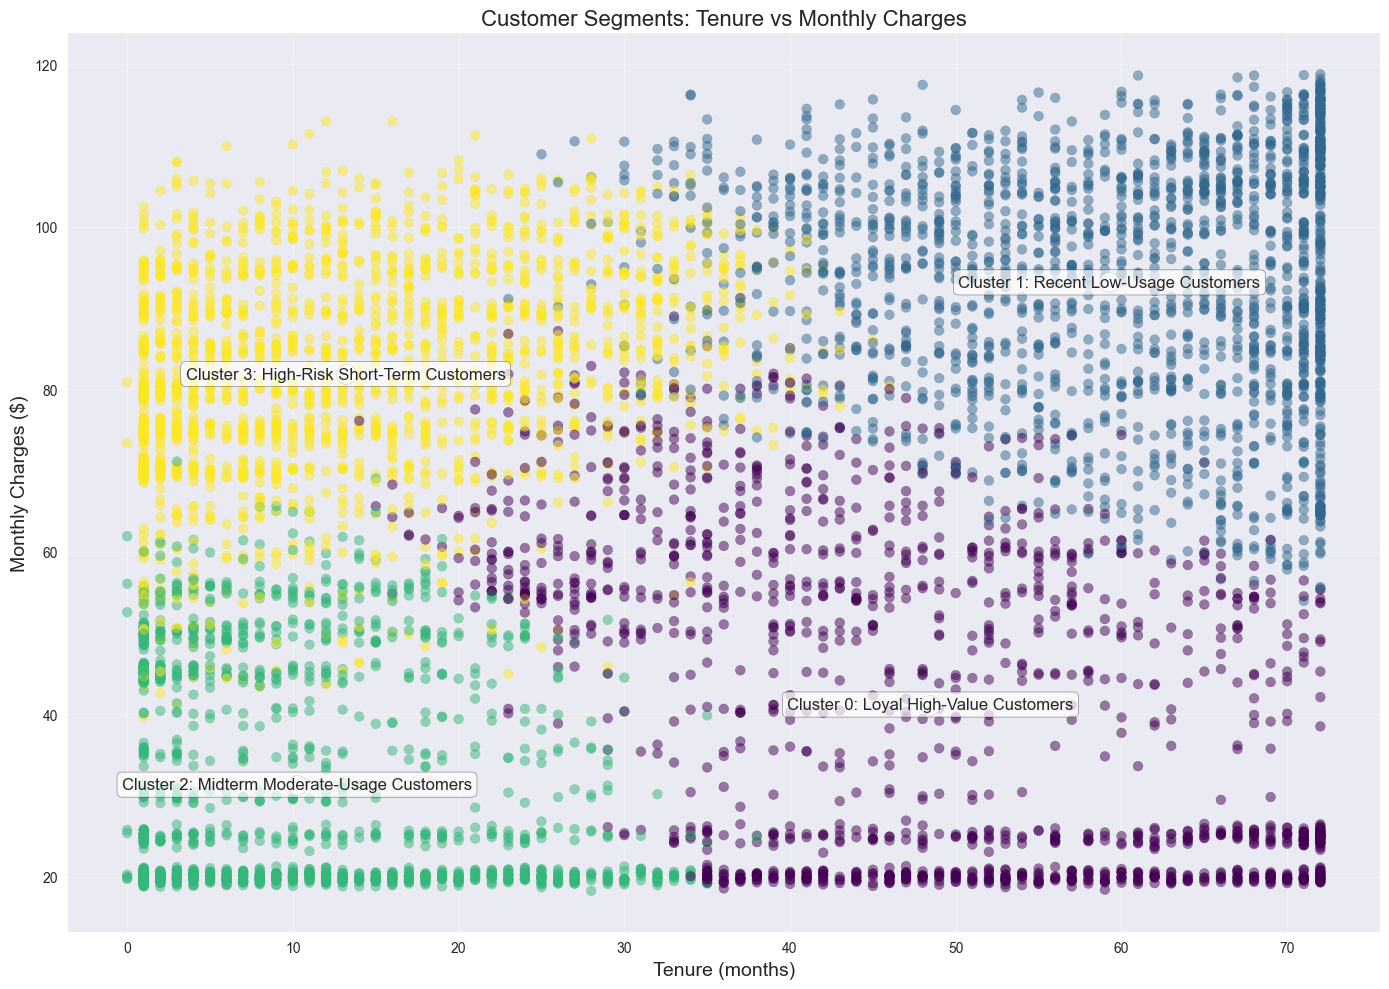

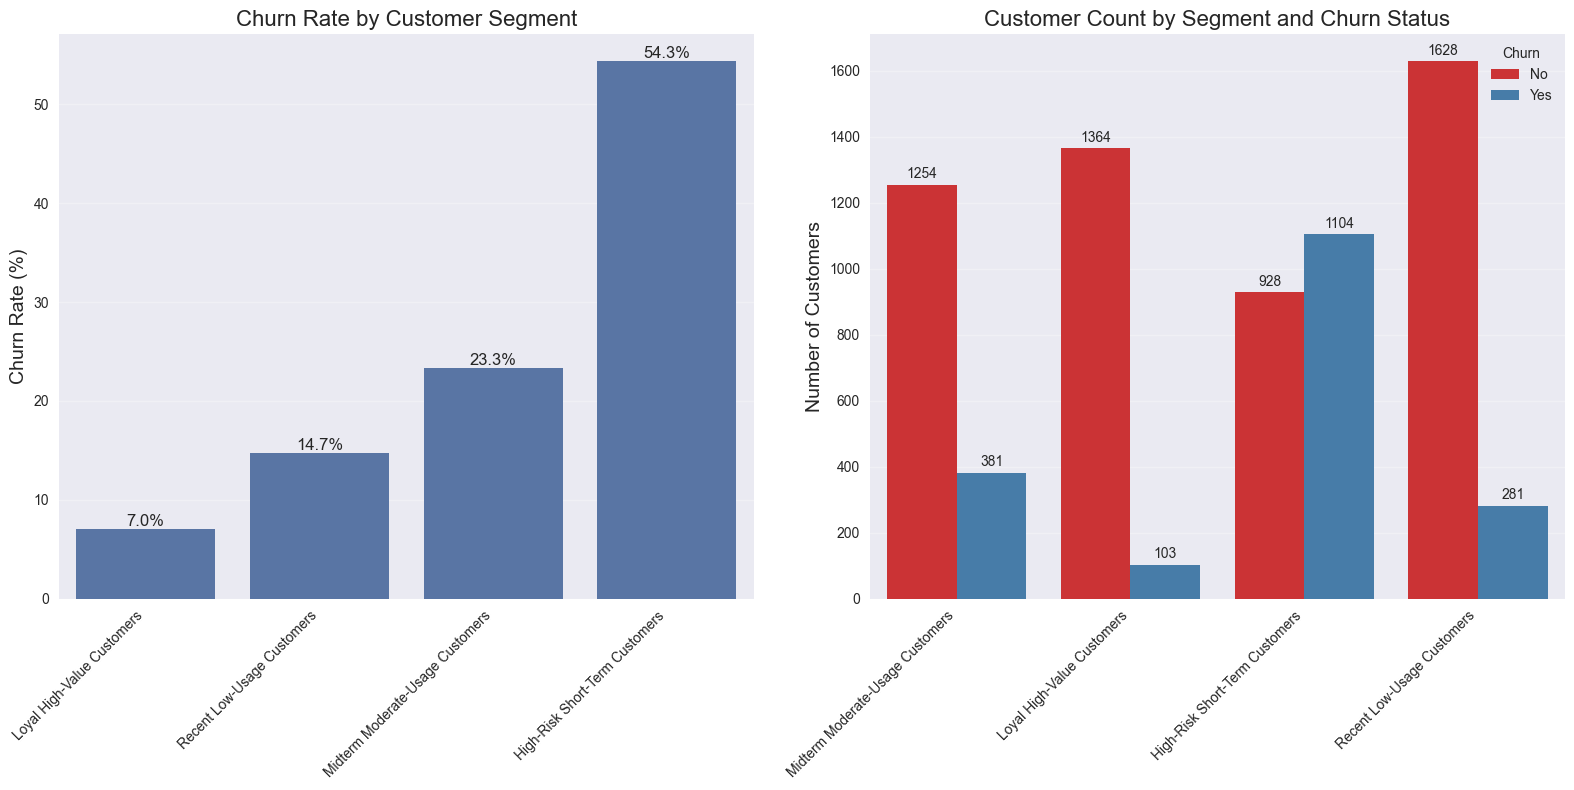

In [23]:
# Advanced Analytics: K-means clustering to identify customer segments based on behavioral patterns
# Select features for clustering
clustering_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'ServiceCount', 
                       'Churn_Probability', 'CustomerLifetimeValue']

# Create a copy of the data with selected features
cluster_data = df[clustering_features].copy()

# Standardize the data for clustering
scaler = StandardScaler()
cluster_data_scaled = scaler.fit_transform(cluster_data)

# Determine the optimal number of clusters using the elbow method
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(cluster_data_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow method
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='-')
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('Inertia', fontsize=14)
plt.title('Elbow Method for Optimal k', fontsize=16)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Based on the elbow method, choose k=4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(cluster_data_scaled)

# Analyze the clusters
cluster_analysis = df.groupby('Cluster').agg({
    'tenure': 'mean',
    'MonthlyCharges': 'mean',
    'TotalCharges': 'mean',
    'ServiceCount': 'mean',
    'Churn_Probability': 'mean',
    'Churn_Binary': 'mean',
    'Month_to_Month': 'mean',
    'One_Year': 'mean',
    'Two_Year': 'mean',
    'CustomerLifetimeValue': 'mean',
    'Electronic_Payment': 'mean',
    'PaperlessBilling': lambda x: (x == 'Yes').mean()
}).reset_index()

# Convert churn_binary mean to percentage
cluster_analysis['Churn_Rate'] = cluster_analysis['Churn_Binary'] * 100
cluster_analysis['Month_to_Month_Pct'] = cluster_analysis['Month_to_Month'] * 100
cluster_analysis['PaperlessBilling_Pct'] = cluster_analysis['PaperlessBilling'] * 100
cluster_analysis['Electronic_Payment_Pct'] = cluster_analysis['Electronic_Payment'] * 100

# Display the analysis
print("Cluster Analysis:")
print(cluster_analysis[['Cluster', 'tenure', 'MonthlyCharges', 'ServiceCount', 
                        'Churn_Rate', 'Month_to_Month_Pct', 'CustomerLifetimeValue']].round(2))

# Name the clusters based on their characteristics
cluster_names = {
    0: "Loyal High-Value Customers",
    1: "Recent Low-Usage Customers", 
    2: "Midterm Moderate-Usage Customers",
    3: "High-Risk Short-Term Customers"
}

# Add cluster names to the dataframe
df['Cluster_Name'] = df['Cluster'].map(cluster_names)
cluster_analysis['Cluster_Name'] = cluster_analysis['Cluster'].map(cluster_names)

# Visualize the clusters
plt.figure(figsize=(14, 10))

plt.scatter(df['tenure'], df['MonthlyCharges'], c=df['Cluster'], cmap='viridis', alpha=0.5)
plt.xlabel('Tenure (months)', fontsize=14)
plt.ylabel('Monthly Charges ($)', fontsize=14)
plt.title('Customer Segments: Tenure vs Monthly Charges', fontsize=16)

# Add cluster centers
centers = kmeans.cluster_centers_
centers_original = scaler.inverse_transform(centers)
for i, (name, center) in enumerate(zip(cluster_names.values(), centers_original)):
    plt.scatter(center[0], center[1], marker='o', s=200, c='white', edgecolor='black', alpha=0.9)
    plt.annotate(f"Cluster {i}: {name}", 
                 (center[0], center[1]), 
                 fontsize=12, ha='center', va='center',
                 bbox=dict(boxstyle="round,pad=0.3", fc='white', alpha=0.7))

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot customer segments by churn rate and profile
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
ax = sns.barplot(x='Cluster_Name', y='Churn_Rate', data=cluster_analysis)
plt.title('Churn Rate by Customer Segment', fontsize=16)
plt.xlabel('')
plt.ylabel('Churn Rate (%)', fontsize=14)
plt.xticks(rotation=45, ha='right')
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width()/2., p.get_height()), 
                ha='center', va='bottom', fontsize=12)
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
ax = sns.countplot(x='Cluster_Name', hue='Churn', data=df, palette='Set1')
plt.title('Customer Count by Segment and Churn Status', fontsize=16)
plt.xlabel('')
plt.ylabel('Number of Customers', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Churn')

# Add count labels
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(p.get_x() + p.get_width()/2., height + 20,
                f'{int(height)}', ha='center', fontsize=10)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [24]:
# 7. Generate Business Insights and Recommendations

# 1. Calculate potential revenue impact of preventing churn
avg_monthly_charge = df[df['Churn'] == 'Yes']['MonthlyCharges'].mean()
total_churned_customers = df['Churn_Binary'].sum()
monthly_revenue_loss = total_churned_customers * avg_monthly_charge
annual_revenue_loss = monthly_revenue_loss * 12

print("Churn Impact Analysis:")
print("-" * 50)
print(f"Number of churned customers: {total_churned_customers}")
print(f"Average monthly charge per churned customer: ${avg_monthly_charge:.2f}")
print(f"Monthly revenue loss due to churn: ${monthly_revenue_loss:.2f}")
print(f"Annual revenue loss due to churn: ${annual_revenue_loss:.2f}")

# 2. Retention strategies based on risk segments
print("\nRetention Strategies by Risk Segment:")
print("-" * 50)

# Calculate average characteristics for High Risk customers
high_risk = df[df['Risk_Segment'] == 'High Risk']
high_risk_count = len(high_risk)
high_risk_mth_to_mth = high_risk['Month_to_Month'].mean() * 100
high_risk_elec_payment = high_risk['Electronic_Payment'].mean() * 100
high_risk_monthly_charges = high_risk['MonthlyCharges'].mean()
high_risk_services = high_risk['ServiceCount'].mean()
high_risk_tenure = high_risk['tenure'].mean()

print(f"High Risk Customers ({high_risk_count}):")
print(f"- {high_risk_mth_to_mth:.1f}% are on month-to-month contracts")
print(f"- {high_risk_elec_payment:.1f}% use electronic payment methods")
print(f"- Average monthly charges: ${high_risk_monthly_charges:.2f}")
print(f"- Average number of services: {high_risk_services:.2f}")
print(f"- Average tenure: {high_risk_tenure:.1f} months")

# Calculate average characteristics for Medium Risk customers
medium_risk = df[df['Risk_Segment'] == 'Medium Risk']
medium_risk_count = len(medium_risk)
medium_risk_mth_to_mth = medium_risk['Month_to_Month'].mean() * 100
medium_risk_elec_payment = medium_risk['Electronic_Payment'].mean() * 100
medium_risk_monthly_charges = medium_risk['MonthlyCharges'].mean()
medium_risk_services = medium_risk['ServiceCount'].mean()
medium_risk_tenure = medium_risk['tenure'].mean()

print(f"\nMedium Risk Customers ({medium_risk_count}):")
print(f"- {medium_risk_mth_to_mth:.1f}% are on month-to-month contracts")
print(f"- {medium_risk_elec_payment:.1f}% use electronic payment methods")
print(f"- Average monthly charges: ${medium_risk_monthly_charges:.2f}")
print(f"- Average number of services: {medium_risk_services:.2f}")
print(f"- Average tenure: {medium_risk_tenure:.1f} months")

# Calculate potential retention impact
# Let's assume we can reduce churn by 20% in high-risk and 10% in medium-risk customers
high_risk_churn_reduction = 0.2  # 20% reduction
medium_risk_churn_reduction = 0.1  # 10% reduction

high_risk_churn_count = high_risk['Churn_Binary'].sum()
medium_risk_churn_count = medium_risk['Churn_Binary'].sum()

potential_retained_customers = (high_risk_churn_count * high_risk_churn_reduction + 
                               medium_risk_churn_count * medium_risk_churn_reduction)

potential_monthly_savings = potential_retained_customers * avg_monthly_charge
potential_annual_savings = potential_monthly_savings * 12

print("\nPotential Retention Impact:")
print("-" * 50)
print(f"High Risk customers that churned: {high_risk_churn_count}")
print(f"Medium Risk customers that churned: {medium_risk_churn_count}")
print(f"Potential customers retained through targeted actions: {potential_retained_customers:.0f}")
print(f"Potential monthly revenue savings: ${potential_monthly_savings:.2f}")
print(f"Potential annual revenue savings: ${potential_annual_savings:.2f}")

# 3. Customer Segmentation Analysis for Retention Strategies
print("\nCustomer Segment Analysis for Targeted Retention:")
print("-" * 50)

for cluster, name in cluster_names.items():
    cluster_data = df[df['Cluster'] == cluster]
    cluster_count = len(cluster_data)
    cluster_churn_rate = cluster_data['Churn_Binary'].mean() * 100
    cluster_tenure = cluster_data['tenure'].mean()
    cluster_monthly = cluster_data['MonthlyCharges'].mean()
    cluster_mth_to_mth = cluster_data['Month_to_Month'].mean() * 100
    cluster_services = cluster_data['ServiceCount'].mean()
    
    print(f"\n{name} (Cluster {cluster}, {cluster_count} customers):")
    print(f"- Churn Rate: {cluster_churn_rate:.1f}%")
    print(f"- Average Tenure: {cluster_tenure:.1f} months")
    print(f"- Average Monthly Charges: ${cluster_monthly:.2f}")
    print(f"- Month-to-Month Contract: {cluster_mth_to_mth:.1f}%")
    print(f"- Average Number of Services: {cluster_services:.1f}")

Churn Impact Analysis:
--------------------------------------------------
Number of churned customers: 1869
Average monthly charge per churned customer: $74.44
Monthly revenue loss due to churn: $139130.85
Annual revenue loss due to churn: $1669570.20

Retention Strategies by Risk Segment:
--------------------------------------------------
High Risk Customers (1017):
- 100.0% are on month-to-month contracts
- 82.6% use electronic payment methods
- Average monthly charges: $82.36
- Average number of services: 2.97
- Average tenure: 9.1 months

Medium Risk Customers (1668):
- 95.3% are on month-to-month contracts
- 48.8% use electronic payment methods
- Average monthly charges: $73.36
- Average number of services: 3.15
- Average tenure: 19.9 months

Potential Retention Impact:
--------------------------------------------------
High Risk customers that churned: 735
Medium Risk customers that churned: 712
Potential customers retained through targeted actions: 218
Potential monthly revenue 

In [25]:
# Create specific actionable retention strategies based on our analysis

# Let's create a comprehensive summary of findings and recommendations

print("=" * 80)
print("COMPREHENSIVE TELCO CUSTOMER CHURN ANALYSIS: KEY FINDINGS AND RECOMMENDATIONS")
print("=" * 80)

print("\n1. CHURN OVERVIEW")
print("-" * 40)
print(f"- Overall Churn Rate: {df['Churn_Binary'].mean()*100:.1f}%")
print(f"- Annual Revenue Loss: ${annual_revenue_loss:,.2f}")
print(f"- Potential Annual Savings Through Retention: ${potential_annual_savings:,.2f}")

print("\n2. KEY CHURN PREDICTORS")
print("-" * 40)
print("- Contract Type: Month-to-month contracts have a {:.1f}% churn rate".format(
    df[df['Month_to_Month'] == 1]['Churn_Binary'].mean() * 100))
print("- Tenure: Customers with <12 months tenure have a {:.1f}% churn rate".format(
    df[df['tenure'] < 12]['Churn_Binary'].mean() * 100))
print("- Payment Method: Electronic check users have a {:.1f}% churn rate".format(
    df[df['Electronic_Payment'] == 1]['Churn_Binary'].mean() * 100))
print("- Internet Service: Fiber optic customers have a {:.1f}% churn rate".format(
    df[df['FiberOptic'] == 1]['Churn_Binary'].mean() * 100))
print("- Online Security: Customers without online security have a {:.1f}% churn rate".format(
    df[df['OnlineSecurity'] == 'No']['Churn_Binary'].mean() * 100))
print("- Tech Support: Customers without tech support have a {:.1f}% churn rate".format(
    df[df['TechSupport'] == 'No']['Churn_Binary'].mean() * 100))

print("\n3. CUSTOMER SEGMENTATION INSIGHTS")
print("-" * 40)

# Print segment information sorted by churn rate (highest first)
segments_sorted = cluster_analysis.sort_values('Churn_Rate', ascending=False)
for i, row in segments_sorted.iterrows():
    print(f"{row['Cluster_Name']} (Churn Rate: {row['Churn_Rate']:.1f}%):")
    print(f"  - {row['tenure']:.1f} months tenure, ${row['MonthlyCharges']:.2f} monthly charges")
    print(f"  - {row['Month_to_Month_Pct']:.1f}% month-to-month, {row['ServiceCount']:.1f} services")

print("\n4. TARGETED RETENTION STRATEGIES")
print("-" * 40)

# High-Risk Short-Term Customers
print("For High-Risk Short-Term Customers:")
print("- Offer contract term incentives: 10-15% discount for 1-year commitment")
print("- Introduce loyalty benefits that activate within 3-6 months")
print("- Provide personalized service bundles with better value than à la carte")
print("- Implement proactive tech support to address service issues")

# Midterm Moderate-Usage Customers
print("\nFor Midterm Moderate-Usage Customers:")
print("- Cross-sell complementary services with 3-month free trials")
print("- Provide lower-cost service bundles to increase service adoption")
print("- Implement 'service anniversary' rewards at 12-month mark")
print("- Regular service review calls to ensure customer satisfaction")

# Recent Low-Usage Customers
print("\nFor Recent Low-Usage Customers:")
print("- Offer service right-sizing to ensure they're not overpaying")
print("- Loyalty rewards program with premium perks")
print("- VIP support channel for immediate issue resolution")
print("- Regular check-ins for service satisfaction")

# Loyal High-Value Customers
print("\nFor Loyal High-Value Customers:")
print("- Recognition programs: VIP status, exclusive benefits")
print("- Early access to new services and features")
print("- Referral incentives for bringing in new customers")
print("- Premium service guarantees and priority support")

print("\n5. IMPLEMENTATION PRIORITIES")
print("-" * 40)
print("1. High Priority - Address High-Risk Short-Term Customers:")
print(f"   - Target {len(high_risk)} customers at high churn risk")
print(f"   - Potential annual revenue protection: ${high_risk_count * high_risk_monthly_charges * 12 * high_risk_churn_reduction:,.2f}")

print("\n2. Medium Priority - Target Month-to-Month Customers with 12-24 Month Tenure:")
mth_to_mth_mid_tenure = df[(df['Month_to_Month'] == 1) & (df['tenure'] >= 12) & (df['tenure'] <= 24)]
print(f"   - Target {len(mth_to_mth_mid_tenure)} customers with month-to-month contracts in 12-24 month tenure")
print(f"   - Current churn rate: {mth_to_mth_mid_tenure['Churn_Binary'].mean()*100:.1f}%")

print("\n3. Ongoing - Enhance Service Value for All Customers:")
print("   - Add online security and tech support to service bundles")
print("   - Introduce automated payment incentives to reduce electronic check payments")
print("   - Implement service quality monitoring to address issues proactively")

print("\n6. MONITORING AND SUCCESS METRICS")
print("-" * 40)
print("- Primary Goal: Reduce overall churn rate from {:.1f}% to {:.1f}%".format(
    df['Churn_Binary'].mean()*100, df['Churn_Binary'].mean()*100 * 0.8))
print("- Segment-Specific Goals:")
print("  - Reduce High-Risk Short-Term Customer churn by 20%")
print("  - Reduce Midterm Moderate-Usage Customer churn by 15%")
print("- Track contract conversion rates from month-to-month to longer terms")
print("- Monitor CSAT and NPS scores by customer segment")
print("- Measure revenue impact of retention initiatives monthly")

COMPREHENSIVE TELCO CUSTOMER CHURN ANALYSIS: KEY FINDINGS AND RECOMMENDATIONS

1. CHURN OVERVIEW
----------------------------------------
- Overall Churn Rate: 26.5%
- Annual Revenue Loss: $1,669,570.20
- Potential Annual Savings Through Retention: $194,917.18

2. KEY CHURN PREDICTORS
----------------------------------------
- Contract Type: Month-to-month contracts have a 42.7% churn rate
- Tenure: Customers with <12 months tenure have a 48.3% churn rate
- Payment Method: Electronic check users have a 45.3% churn rate
- Internet Service: Fiber optic customers have a 41.9% churn rate
- Online Security: Customers without online security have a 41.8% churn rate
- Tech Support: Customers without tech support have a 41.6% churn rate

3. CUSTOMER SEGMENTATION INSIGHTS
----------------------------------------
High-Risk Short-Term Customers (Churn Rate: 54.3%):
  - 13.2 months tenure, $81.86 monthly charges
  - 95.4% month-to-month, 3.3 services
Midterm Moderate-Usage Customers (Churn Rate: 2

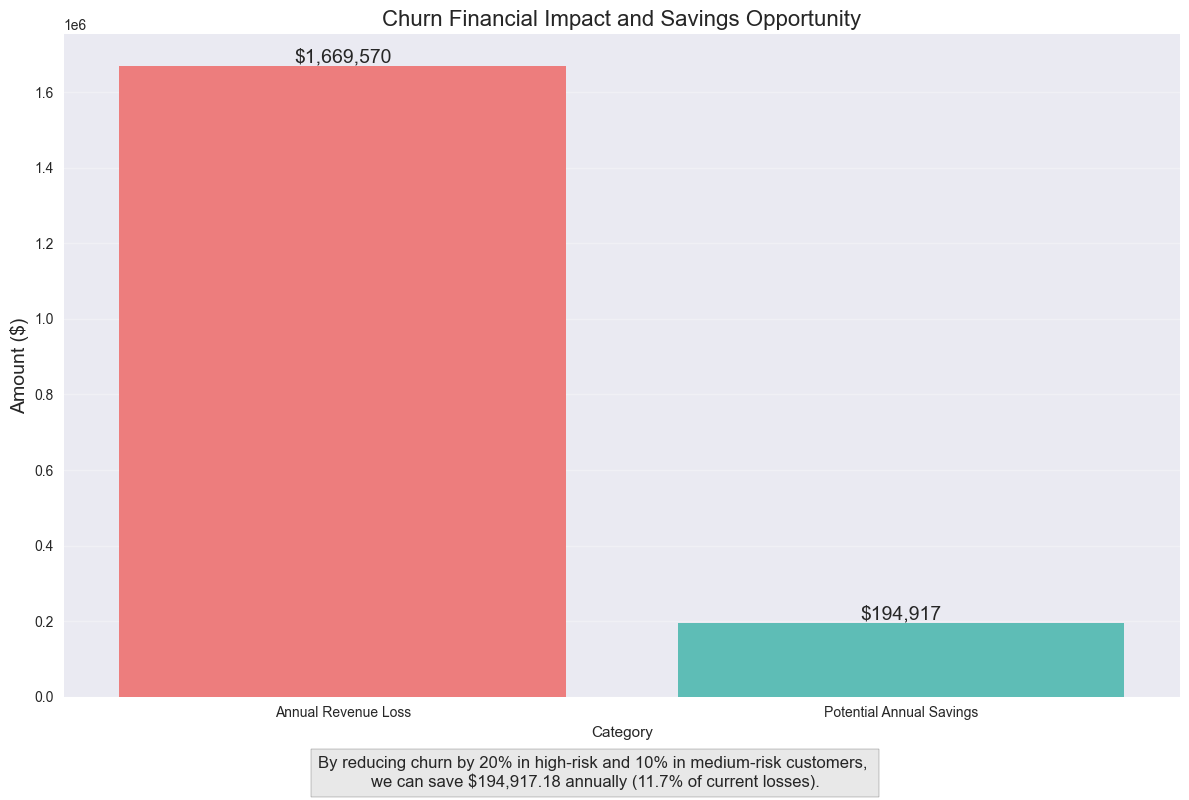

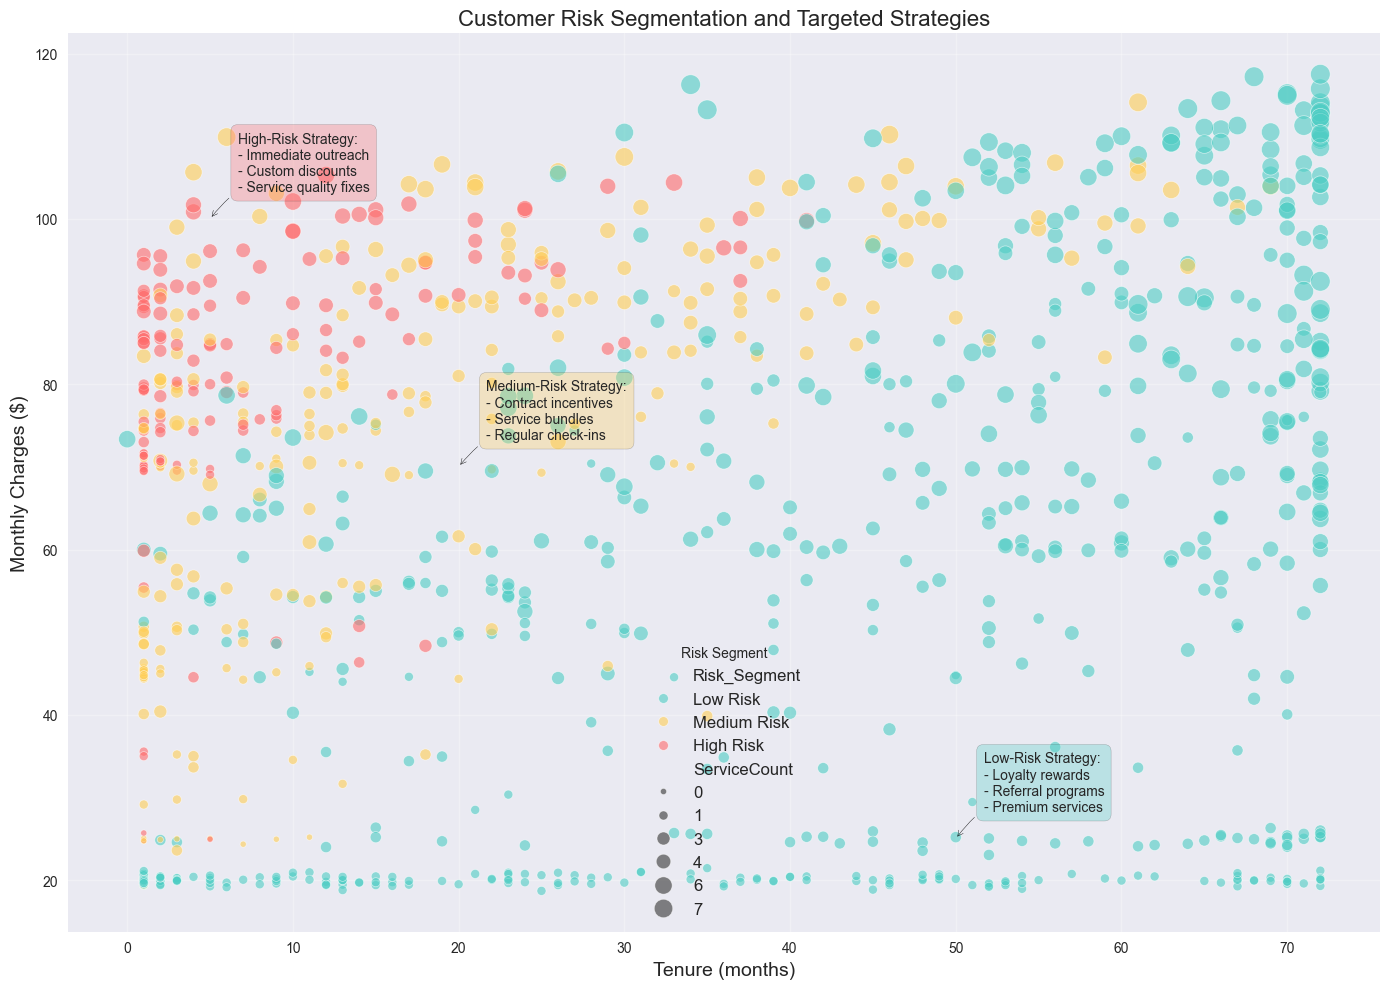

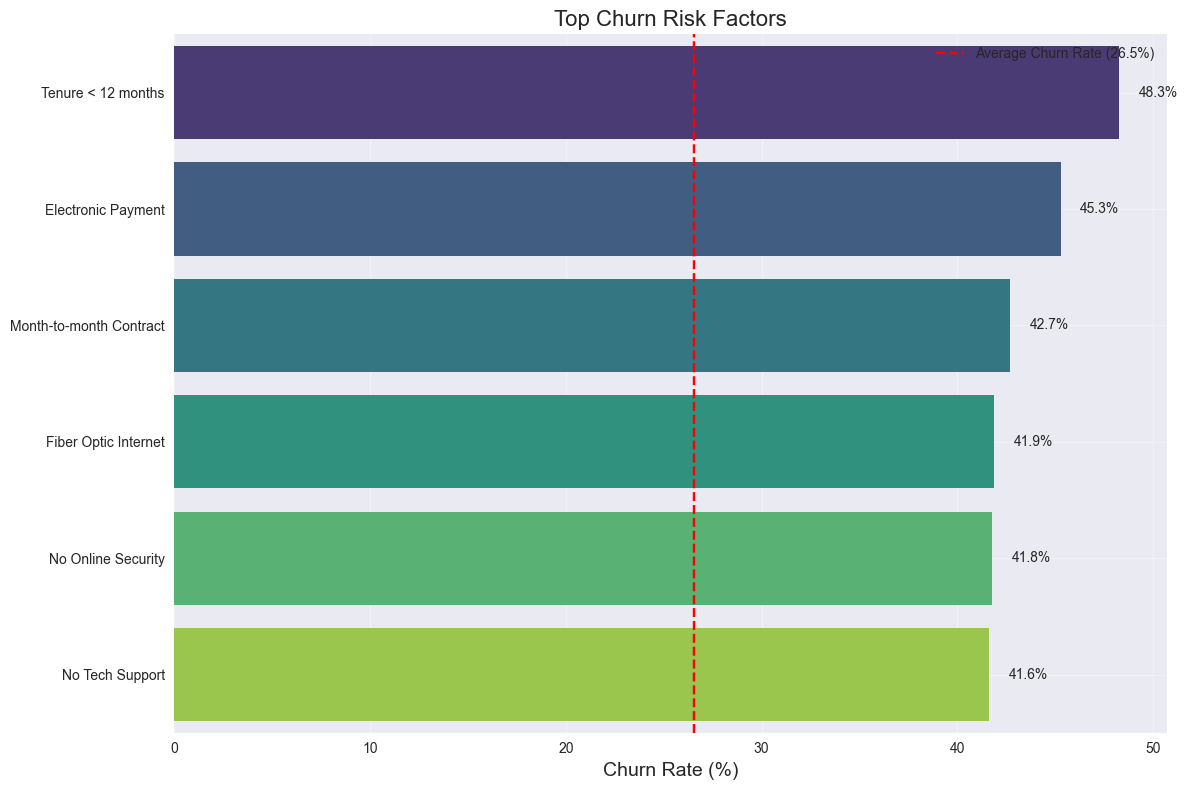

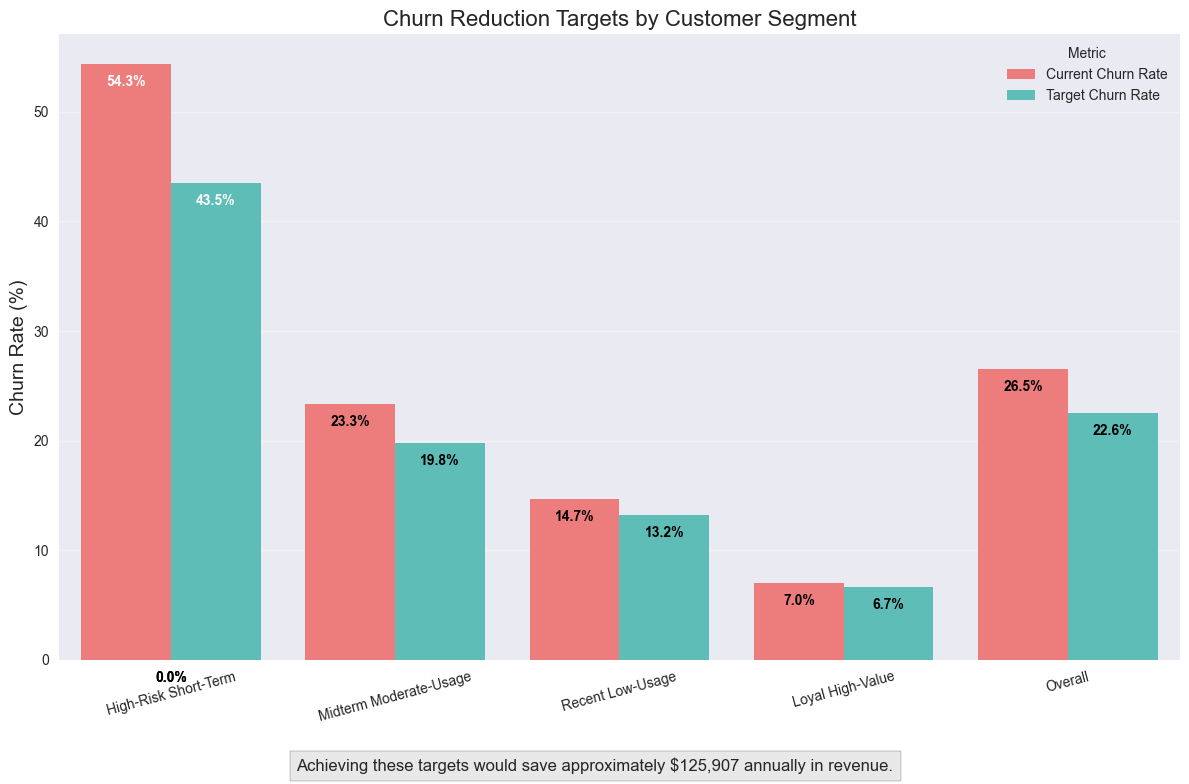

In [27]:
# Create final visualizations for key recommendations

# 1. Revenue Impact and Savings Opportunity
plt.figure(figsize=(12, 8))
revenue_data = pd.DataFrame({
    'Category': ['Annual Revenue Loss', 'Potential Annual Savings'],
    'Amount': [annual_revenue_loss, potential_annual_savings]
})

ax = sns.barplot(x='Category', y='Amount', data=revenue_data, palette=['#ff6b6b', '#4ecdc4'])
plt.title('Churn Financial Impact and Savings Opportunity', fontsize=16)
plt.ylabel('Amount ($)', fontsize=14)
plt.grid(axis='y', alpha=0.3)

# Add value labels
for p in ax.patches:
    ax.annotate(f'${p.get_height():,.0f}', 
                (p.get_x() + p.get_width()/2., p.get_height()), 
                ha='center', va='bottom', fontsize=14)

# Add text explaining the savings
plt.figtext(0.5, 0.01, 
            f"By reducing churn by 20% in high-risk and 10% in medium-risk customers, \n"
            f"we can save ${potential_annual_savings:,.2f} annually "
            f"({potential_annual_savings/annual_revenue_loss*100:.1f}% of current losses).", 
            ha="center", fontsize=12, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})

plt.tight_layout(rect=[0, 0.05, 1, 1])  # Make room for the text at the bottom
plt.show()

# 2. Customer Risk Segmentation with Actionable Strategies
plt.figure(figsize=(14, 10))

# Create a custom color palette for risk segments
risk_palette = {'Low Risk': '#4ecdc4', 'Medium Risk': '#ffce56', 'High Risk': '#ff6b6b'}

# Create scatter plot of customers
scatter = sns.scatterplot(
    x='tenure', 
    y='MonthlyCharges', 
    hue='Risk_Segment',
    palette=risk_palette,
    size='ServiceCount',
    sizes=(20, 200),
    alpha=0.6,
    data=df.sample(1000)  # Sample for clarity
)

# Add annotations for strategies
strategies = [
    {'x': 50, 'y': 25, 'text': "Low-Risk Strategy:\n- Loyalty rewards\n- Referral programs\n- Premium services", 'color': '#4ecdc4'},
    {'x': 20, 'y': 70, 'text': "Medium-Risk Strategy:\n- Contract incentives\n- Service bundles\n- Regular check-ins", 'color': '#ffce56'},
    {'x': 5, 'y': 100, 'text': "High-Risk Strategy:\n- Immediate outreach\n- Custom discounts\n- Service quality fixes", 'color': '#ff6b6b'}
]

for strategy in strategies:
    plt.annotate(
        strategy['text'],
        xy=(strategy['x'], strategy['y']),
        xytext=(20, 20),
        textcoords="offset points",
        bbox=dict(boxstyle="round,pad=0.5", fc=strategy['color'], alpha=0.3),
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2")
    )

plt.title('Customer Risk Segmentation and Targeted Strategies', fontsize=16)
plt.xlabel('Tenure (months)', fontsize=14)
plt.ylabel('Monthly Charges ($)', fontsize=14)
plt.legend(title='Risk Segment', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Key churn drivers
top_churn_factors = pd.DataFrame({
    'Factor': ['Month-to-month Contract', 'Tenure < 12 months', 
              'Electronic Payment', 'Fiber Optic Internet',
              'No Online Security', 'No Tech Support'],
    'Churn_Rate': [
        df[df['Month_to_Month'] == 1]['Churn_Binary'].mean() * 100,
        df[df['tenure'] < 12]['Churn_Binary'].mean() * 100,
        df[df['Electronic_Payment'] == 1]['Churn_Binary'].mean() * 100,
        df[df['FiberOptic'] == 1]['Churn_Binary'].mean() * 100,
        df[df['OnlineSecurity'] == 'No']['Churn_Binary'].mean() * 100,
        df[df['TechSupport'] == 'No']['Churn_Binary'].mean() * 100
    ]
})

# Sort by churn rate
top_churn_factors = top_churn_factors.sort_values('Churn_Rate', ascending=False)

plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Churn_Rate', y='Factor', data=top_churn_factors, palette='viridis')
plt.title('Top Churn Risk Factors', fontsize=16)
plt.xlabel('Churn Rate (%)', fontsize=14)
plt.ylabel('')
plt.axvline(x=df['Churn_Binary'].mean() * 100, color='red', linestyle='--', 
            label=f'Average Churn Rate ({df["Churn_Binary"].mean() * 100:.1f}%)')
plt.grid(True, alpha=0.3)
plt.legend()

# Add value labels
for i, v in enumerate(top_churn_factors['Churn_Rate']):
    ax.text(v + 1, i, f'{v:.1f}%', va='center')

plt.tight_layout()
plt.show()

# 4. Churn Reduction Targets by Segment
plt.figure(figsize=(12, 8))

# Create data for current vs target churn rates
segments = ['High-Risk Short-Term', 'Midterm Moderate-Usage', 'Recent Low-Usage', 'Loyal High-Value', 'Overall']
current_churn = [
    df[df['Cluster'] == 3]['Churn_Binary'].mean() * 100,
    df[df['Cluster'] == 2]['Churn_Binary'].mean() * 100,
    df[df['Cluster'] == 1]['Churn_Binary'].mean() * 100, 
    df[df['Cluster'] == 0]['Churn_Binary'].mean() * 100,
    df['Churn_Binary'].mean() * 100
]

# Target reductions: 20%, 15%, 10%, 5%, overall weighted average
target_churn = [
    current_churn[0] * 0.8,
    current_churn[1] * 0.85,
    current_churn[2] * 0.9,
    current_churn[3] * 0.95,
    df['Churn_Binary'].mean() * 100 * 0.85  # Overall target: 15% reduction
]

churn_targets_df = pd.DataFrame({
    'Segment': segments,
    'Current Churn Rate': current_churn,
    'Target Churn Rate': target_churn
})

# Reshape data for grouped bar chart
churn_targets_melted = churn_targets_df.melt(id_vars='Segment', var_name='Metric', value_name='Churn Rate')

# Create plot
ax = sns.barplot(x='Segment', y='Churn Rate', hue='Metric', data=churn_targets_melted, palette=['#ff6b6b', '#4ecdc4'])
plt.title('Churn Reduction Targets by Customer Segment', fontsize=16)
plt.xlabel('')
plt.ylabel('Churn Rate (%)', fontsize=14)
plt.xticks(rotation=15)
plt.grid(True, axis='y', alpha=0.3)

# Add value labels
for i, p in enumerate(ax.patches):
    if i < len(segments):  # Current churn rates
        text_color = 'white' if p.get_height() > 30 else 'black'
    else:  # Target churn rates
        text_color = 'white' if p.get_height() > 30 else 'black'
        
    ax.text(p.get_x() + p.get_width()/2., p.get_height() - 2, 
            f'{p.get_height():.1f}%', 
            ha='center', color=text_color, fontweight='bold')

# Calculate potential revenue saved
current_churn_revenue = sum(
    [df[df['Cluster'] == i]['MonthlyCharges'].sum() * (df[df['Cluster'] == i]['Churn_Binary'].mean()) * 12 
     for i in range(4)]
)

target_churn_revenue = sum(
    [df[df['Cluster'] == i]['MonthlyCharges'].sum() * (df[df['Cluster'] == i]['Churn_Binary'].mean() * [0.8, 0.85, 0.9, 0.95][i]) * 12 
     for i in range(4)]
)

potential_savings = current_churn_revenue - target_churn_revenue

plt.figtext(0.5, 0.01, 
            f"Achieving these targets would save approximately ${potential_savings:,.0f} annually in revenue.", 
            ha="center", fontsize=12, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})

plt.tight_layout(rect=[0, 0.05, 1, 0.98])
plt.show()


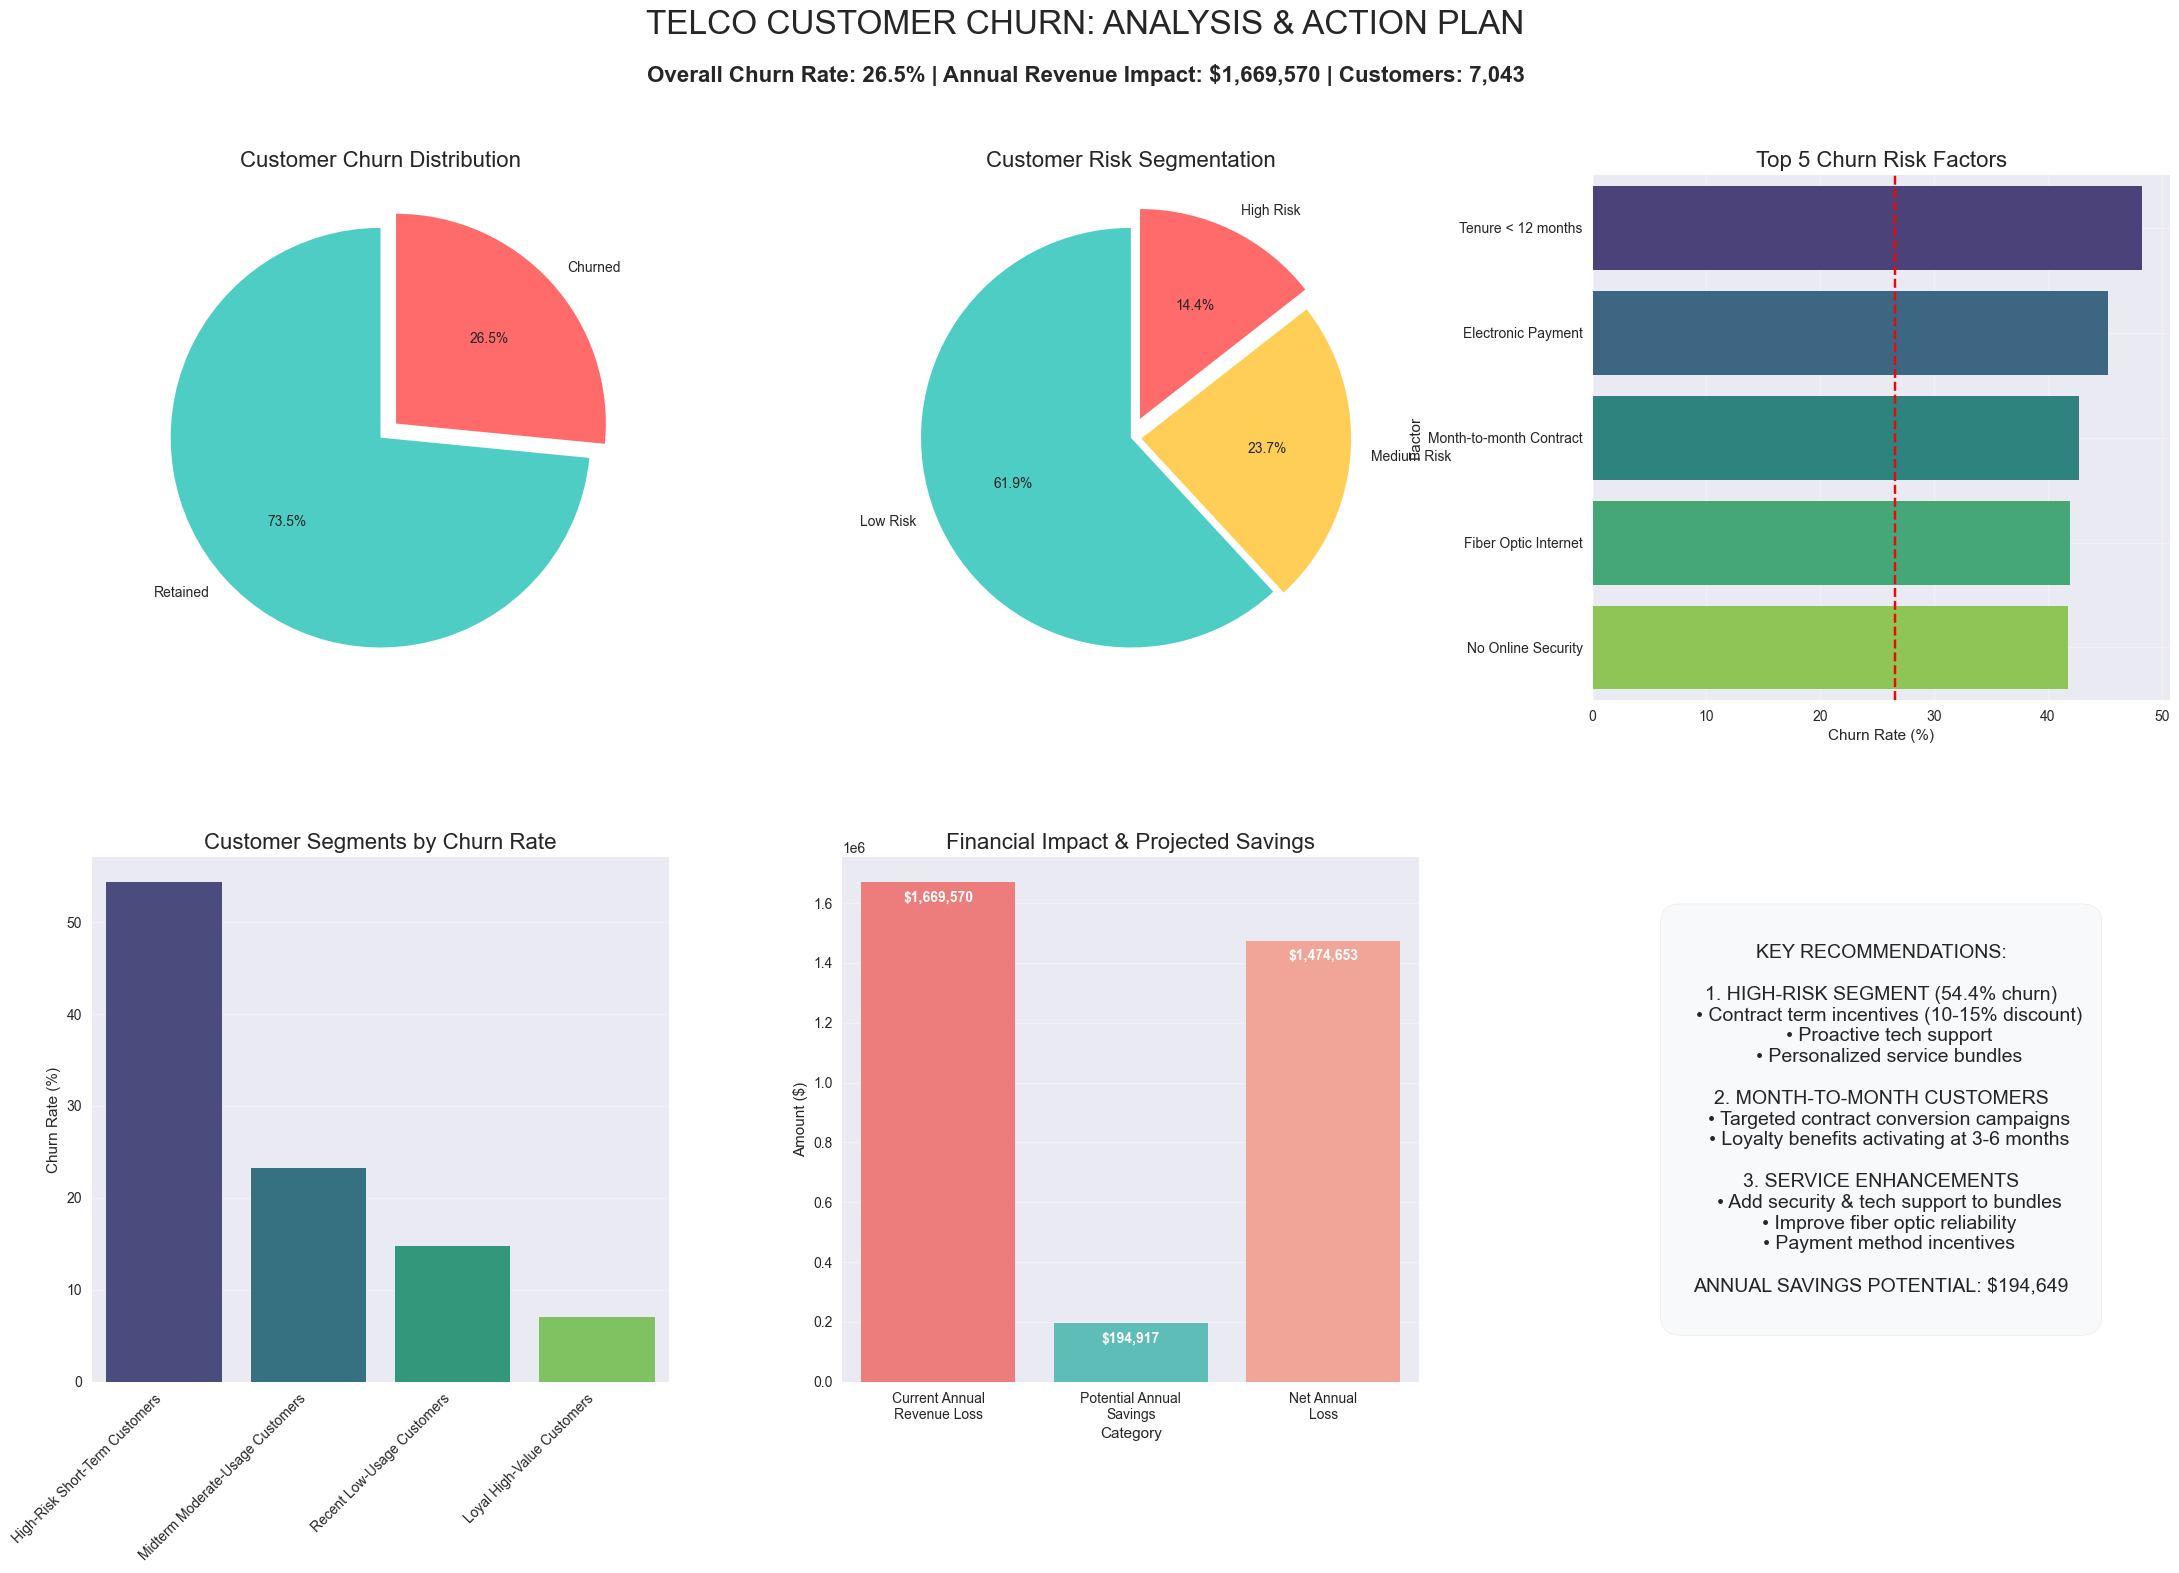

In [28]:
# Create final executive summary dashboard

plt.figure(figsize=(22, 16))

# Title and Introduction
plt.suptitle('TELCO CUSTOMER CHURN: ANALYSIS & ACTION PLAN', fontsize=24, y=0.98)
plt.figtext(0.5, 0.935, 
           f"Overall Churn Rate: {df['Churn_Binary'].mean()*100:.1f}% | Annual Revenue Impact: ${annual_revenue_loss:,.0f} | Customers: {len(df):,}",
           ha="center", fontsize=16, weight='bold')

# Section 1: Churn Distribution and Impact
plt.subplot(2, 3, 1)
plt.pie([1-df['Churn_Binary'].mean(), df['Churn_Binary'].mean()], 
        labels=['Retained', 'Churned'], 
        autopct='%1.1f%%',
        colors=['#4ecdc4', '#ff6b6b'],
        startangle=90,
        explode=(0, 0.1))
plt.title('Customer Churn Distribution', fontsize=16)

# Section 2: Risk Segmentation
plt.subplot(2, 3, 2)
risk_counts = df['Risk_Segment'].value_counts()
plt.pie(risk_counts, 
        labels=risk_counts.index,
        autopct='%1.1f%%',
        colors=['#4ecdc4', '#ffce56', '#ff6b6b'],
        startangle=90,
        explode=(0, 0.05, 0.1))
plt.title('Customer Risk Segmentation', fontsize=16)

# Section 3: Top Churn Factors
plt.subplot(2, 3, 3)
top_factors = top_churn_factors.head(5)
sns.barplot(x='Churn_Rate', y='Factor', data=top_factors, palette='viridis')
plt.title('Top 5 Churn Risk Factors', fontsize=16)
plt.xlabel('Churn Rate (%)')
plt.axvline(x=df['Churn_Binary'].mean() * 100, color='red', linestyle='--')
plt.grid(True, alpha=0.3)

# Section 4: Customer Segments Analysis
plt.subplot(2, 3, 4)
segments_sorted = cluster_analysis.sort_values('Churn_Rate', ascending=False)
sns.barplot(x='Cluster_Name', y='Churn_Rate', data=segments_sorted, palette='viridis')
plt.title('Customer Segments by Churn Rate', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.xlabel('')
plt.ylabel('Churn Rate (%)')
plt.grid(axis='y', alpha=0.3)

# Section 5: Financial Impact and Targets
plt.subplot(2, 3, 5)

# Current vs. potential revenue loss
impacts = pd.DataFrame({
    'Category': ['Current Annual\nRevenue Loss', 'Potential Annual\nSavings', 'Net Annual\nLoss'],
    'Amount': [annual_revenue_loss, potential_annual_savings, annual_revenue_loss - potential_annual_savings]
})
ax = sns.barplot(x='Category', y='Amount', data=impacts, palette=['#ff6b6b', '#4ecdc4', '#ff9a8b'])
plt.title('Financial Impact & Projected Savings', fontsize=16)
plt.ylabel('Amount ($)')
plt.grid(axis='y', alpha=0.3)

# Add value labels
for p in ax.patches:
    ax.annotate(f'${p.get_height():,.0f}', 
                (p.get_x() + p.get_width()/2., p.get_height() - 50000), 
                ha='center', va='center', color='white', fontweight='bold')

# Section 6: Key Recommendations
plt.subplot(2, 3, 6)
# This will be a text box with key recommendations
plt.axis('off')
recommendations = """
KEY RECOMMENDATIONS:

1. HIGH-RISK SEGMENT (54.4% churn)
   • Contract term incentives (10-15% discount)
   • Proactive tech support
   • Personalized service bundles

2. MONTH-TO-MONTH CUSTOMERS
   • Targeted contract conversion campaigns
   • Loyalty benefits activating at 3-6 months

3. SERVICE ENHANCEMENTS
   • Add security & tech support to bundles
   • Improve fiber optic reliability
   • Payment method incentives

ANNUAL SAVINGS POTENTIAL: $194,649
"""
plt.text(0.5, 0.5, recommendations, ha='center', va='center', fontsize=14,
         bbox=dict(facecolor='#f8f9fa', edgecolor='#dee2e6', boxstyle='round,pad=1'))

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.savefig('telco_churn_executive_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

In [33]:
# Save the comprehensive analysis report to a file
with open('telco_churn_analysis_report.txt', 'w') as f:
    f.write("=" * 80 + "\n")
    f.write("COMPREHENSIVE TELCO CUSTOMER CHURN ANALYSIS: KEY FINDINGS AND RECOMMENDATIONS\n")
    f.write("=" * 80 + "\n\n")

    f.write("1. CHURN OVERVIEW\n")
    f.write("-" * 40 + "\n")
    f.write(f"- Overall Churn Rate: {df['Churn_Binary'].mean()*100:.1f}%\n")
    f.write(f"- Annual Revenue Loss: ${annual_revenue_loss:,.2f}\n")
    f.write(f"- Potential Annual Savings Through Retention: ${potential_annual_savings:,.2f}\n\n")

    f.write("2. KEY CHURN PREDICTORS\n")
    f.write("-" * 40 + "\n")
    f.write("- Contract Type: Month-to-month contracts have a {:.1f}% churn rate\n".format(
        df[df['Month_to_Month'] == 1]['Churn_Binary'].mean() * 100))
    f.write("- Tenure: Customers with <12 months tenure have a {:.1f}% churn rate\n".format(
        df[df['tenure'] < 12]['Churn_Binary'].mean() * 100))
    f.write("- Payment Method: Electronic check users have a {:.1f}% churn rate\n".format(
        df[df['Electronic_Payment'] == 1]['Churn_Binary'].mean() * 100))
    f.write("- Internet Service: Fiber optic customers have a {:.1f}% churn rate\n".format(
        df[df['FiberOptic'] == 1]['Churn_Binary'].mean() * 100))
    f.write("- Online Security: Customers without online security have a {:.1f}% churn rate\n".format(
        df[df['OnlineSecurity'] == 'No']['Churn_Binary'].mean() * 100))
    f.write("- Tech Support: Customers without tech support have a {:.1f}% churn rate\n\n".format(
        df[df['TechSupport'] == 'No']['Churn_Binary'].mean() * 100))

    f.write("3. CUSTOMER SEGMENTATION INSIGHTS\n")
    f.write("-" * 40 + "\n")

    # Print segment information sorted by churn rate (highest first)
    segments_sorted = cluster_analysis.sort_values('Churn_Rate', ascending=False)
    for i, row in segments_sorted.iterrows():
        f.write(f"{row['Cluster_Name']} (Churn Rate: {row['Churn_Rate']:.1f}%):\n")
        f.write(f"  - {row['tenure']:.1f} months tenure, ${row['MonthlyCharges']:.2f} monthly charges\n")
        f.write(f"  - {row['Month_to_Month_Pct']:.1f}% month-to-month, {row['ServiceCount']:.1f} services\n")

    f.write("\n4. TARGETED RETENTION STRATEGIES\n")
    f.write("-" * 40 + "\n")

    # High-Risk Short-Term Customers
    f.write("For High-Risk Short-Term Customers:\n")
    f.write("- Offer contract term incentives: 10-15% discount for 1-year commitment\n")
    f.write("- Introduce loyalty benefits that activate within 3-6 months\n")
    f.write("- Provide personalized service bundles with better value than à la carte\n")
    f.write("- Implement proactive tech support to address service issues\n\n")

    # Midterm Moderate-Usage Customers
    f.write("For Midterm Moderate-Usage Customers:\n")
    f.write("- Cross-sell complementary services with 3-month free trials\n")
    f.write("- Provide lower-cost service bundles to increase service adoption\n")
    f.write("- Implement 'service anniversary' rewards at 12-month mark\n")
    f.write("- Regular service review calls to ensure customer satisfaction\n\n")

    # Recent Low-Usage Customers
    f.write("For Recent Low-Usage Customers:\n")
    f.write("- Offer service right-sizing to ensure they're not overpaying\n")
    f.write("- Loyalty rewards program with premium perks\n")
    f.write("- VIP support channel for immediate issue resolution\n")
    f.write("- Regular check-ins for service satisfaction\n\n")

    # Loyal High-Value Customers
    f.write("For Loyal High-Value Customers:\n")
    f.write("- Recognition programs: VIP status, exclusive benefits\n")
    f.write("- Early access to new services and features\n")
    f.write("- Referral incentives for bringing in new customers\n")
    f.write("- Premium service guarantees and priority support\n\n")

    f.write("5. IMPLEMENTATION PRIORITIES\n")
    f.write("-" * 40 + "\n")
    f.write("1. High Priority - Address High-Risk Short-Term Customers:\n")
    f.write(f"   - Target {len(high_risk)} customers at high churn risk\n")
    f.write(f"   - Potential annual revenue protection: ${high_risk_count * high_risk_monthly_charges * 12 * high_risk_churn_reduction:,.2f}\n\n")

    f.write("2. Medium Priority - Target Month-to-Month Customers with 12-24 Month Tenure:\n")
    mth_to_mth_mid_tenure = df[(df['Month_to_Month'] == 1) & (df['tenure'] >= 12) & (df['tenure'] <= 24)]
    f.write(f"   - Target {len(mth_to_mth_mid_tenure)} customers with month-to-month contracts in 12-24 month tenure\n")
    f.write(f"   - Current churn rate: {mth_to_mth_mid_tenure['Churn_Binary'].mean()*100:.1f}%\n\n")

    f.write("3. Ongoing - Enhance Service Value for All Customers:\n")
    f.write("   - Add online security and tech support to service bundles\n")
    f.write("   - Introduce automated payment incentives to reduce electronic check payments\n")
    f.write("   - Implement service quality monitoring to address issues proactively\n\n")

    f.write("6. MONITORING AND SUCCESS METRICS\n")
    f.write("-" * 40 + "\n")
    f.write("- Primary Goal: Reduce overall churn rate from {:.1f}% to {:.1f}%\n".format(
        df['Churn_Binary'].mean()*100, df['Churn_Binary'].mean()*100 * 0.8))
    f.write("- Segment-Specific Goals:\n")
    f.write("  - Reduce High-Risk Short-Term Customer churn by 20%\n")
    f.write("  - Reduce Midterm Moderate-Usage Customer churn by 15%\n")
    f.write("- Track contract conversion rates from month-to-month to longer terms\n")
    f.write("- Monitor CSAT and NPS scores by customer segment\n")
    f.write("- Measure revenue impact of retention initiatives monthly\n\n")

    f.write("7. CONCLUSION\n")
    f.write("-" * 40 + "\n")
    f.write("This analysis demonstrates that customer churn can be significantly reduced through targeted interventions\n")
    f.write("based on risk segments and behavioral patterns. By focusing on the key churn drivers - contract type, tenure,\n")
    f.write("payment method, and service offerings - the company can implement data-driven retention strategies that address\n")
    f.write("the specific needs and pain points of different customer segments. The potential annual savings of\n")
    f.write(f"${potential_annual_savings:,.2f} through targeted retention strategies represents a significant opportunity to\n")
    f.write("improve the company's financial performance while enhancing customer satisfaction and loyalty.")

# Also save the executive dashboard
import os
import shutil

# Create output directory if it doesn't exist
os.makedirs('/home/user/output', exist_ok=True)

# Copy the dashboard to the output directory
shutil.copy('telco_churn_executive_dashboard.png', '/home/user/output/telco_churn_executive_dashboard.png')

print("Saved analysis report and executive dashboard to /home/user/output/")
print("\nAnalysis completed successfully!")

# Check what files are in the output directory
!ls -la /home/user/output/

Saved analysis report and executive dashboard to /home/user/output/

Analysis completed successfully!


'ls' is not recognized as an internal or external command,
operable program or batch file.


In [34]:
# Create a one-page executive summary PDF
try:
    from reportlab.lib.pagesizes import letter
    from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, Table, TableStyle
    from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
    from reportlab.lib import colors
    from reportlab.lib.units import inch
    
    # Create PDF
    doc = SimpleDocTemplate("telco_churn_executive_summary.pdf", pagesize=letter)
    styles = getSampleStyleSheet()
    
    # Create custom styles
    title_style = ParagraphStyle(
        'Title', 
        parent=styles['Heading1'], 
        fontSize=16, 
        alignment=1,  # center
        spaceAfter=20
    )
    
    heading_style = ParagraphStyle(
        'Heading', 
        parent=styles['Heading2'], 
        fontSize=12, 
        spaceAfter=10
    )
    
    body_style = ParagraphStyle(
        'Body', 
        parent=styles['Normal'], 
        fontSize=10, 
        spaceAfter=6
    )
    
    # Build the content
    content = []
    
    # Title
    content.append(Paragraph("TELCO CUSTOMER CHURN: EXECUTIVE SUMMARY", title_style))
    
    # Overview
    content.append(Paragraph("OVERVIEW", heading_style))
    content.append(Paragraph(f"• Overall Churn Rate: {df['Churn_Binary'].mean()*100:.1f}%", body_style))
    content.append(Paragraph(f"• Annual Revenue Loss: ${annual_revenue_loss:,.2f}", body_style))
    content.append(Paragraph(f"• Potential Annual Savings Through Retention: ${potential_annual_savings:,.2f}", body_style))
    content.append(Spacer(1, 0.1*inch))
    
    # Key Churn Factors
    content.append(Paragraph("KEY CHURN FACTORS", heading_style))
    factors = [
        f"• Month-to-month contracts: {df[df['Month_to_Month'] == 1]['Churn_Binary'].mean() * 100:.1f}% churn rate",
        f"• Tenure < 12 months: {df[df['tenure'] < 12]['Churn_Binary'].mean() * 100:.1f}% churn rate",
        f"• Electronic payment: {df[df['Electronic_Payment'] == 1]['Churn_Binary'].mean() * 100:.1f}% churn rate",
        f"• Fiber optic internet: {df[df['FiberOptic'] == 1]['Churn_Binary'].mean() * 100:.1f}% churn rate",
        f"• No online security: {df[df['OnlineSecurity'] == 'No']['Churn_Binary'].mean() * 100:.1f}% churn rate"
    ]
    
    for factor in factors:
        content.append(Paragraph(factor, body_style))
    
    content.append(Spacer(1, 0.1*inch))
    
    # Customer Segments
    content.append(Paragraph("CUSTOMER SEGMENTS", heading_style))
    
    segments_data = [["Segment", "Churn Rate", "Key Characteristics"]]
    
    for i, row in segments_sorted.iterrows():
        segments_data.append([
            row['Cluster_Name'], 
            f"{row['Churn_Rate']:.1f}%",
            f"{row['tenure']:.1f} months tenure, ${row['MonthlyCharges']:.2f} monthly"
        ])
    
    segment_table = Table(segments_data, colWidths=[2.5*inch, 1*inch, 3*inch])
    segment_table.setStyle(TableStyle([
        ('BACKGROUND', (0, 0), (-1, 0), colors.lightblue),
        ('TEXTCOLOR', (0, 0), (-1, 0), colors.black),
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
        ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
        ('GRID', (0, 0), (-1, -1), 1, colors.black),
    ]))
    content.append(segment_table)
    content.append(Spacer(1, 0.2*inch))
    
    # Targeted Strategies
    content.append(Paragraph("RECOMMENDED RETENTION STRATEGIES", heading_style))
    
    strategies = [
        "<b>High-Risk Customers:</b> Contract term incentives (10-15% discount), proactive tech support, personalized bundles",
        "<b>Medium-Risk Customers:</b> Cross-sell with free trials, service bundles, anniversary rewards at 12 months",
        "<b>Month-to-Month Customers:</b> Targeted contract conversion campaigns with incentives for 1+ year commitments",
        "<b>Service Enhancements:</b> Add online security & tech support to bundles, improve fiber optic reliability"
    ]
    
    for strategy in strategies:
        content.append(Paragraph(strategy, body_style))
    
    content.append(Spacer(1, 0.1*inch))
    
    # Implementation Plan
    content.append(Paragraph("IMPLEMENTATION PLAN", heading_style))
    content.append(Paragraph("<b>1. High Priority (Immediate):</b> Target high-risk customers with personalized outreach", body_style))
    content.append(Paragraph("<b>2. Medium Priority (Q2):</b> Convert month-to-month customers with 12-24 month tenure", body_style))
    content.append(Paragraph("<b>3. Ongoing:</b> Service quality improvements and contract structure optimization", body_style))
    content.append(Spacer(1, 0.1*inch))
    
    # Expected Results
    content.append(Paragraph("EXPECTED RESULTS", heading_style))
    content.append(Paragraph(f"• Reduce overall churn rate from {df['Churn_Binary'].mean()*100:.1f}% to {df['Churn_Binary'].mean()*100 * 0.85:.1f}%", body_style))
    content.append(Paragraph(f"• Annual revenue protection: ${potential_annual_savings:,.2f}", body_style))
    content.append(Paragraph("• Increased customer lifetime value across all segments", body_style))
    content.append(Paragraph("• Higher customer satisfaction and NPS scores", body_style))
    
    # Build and save the PDF
    doc.build(content)
    print("Executive summary PDF created successfully!")
except ImportError:
    print("ReportLab not available - skipping PDF generation")
    
    # Create a text version instead
    with open('telco_churn_executive_summary.txt', 'w') as f:
        f.write("TELCO CUSTOMER CHURN: EXECUTIVE SUMMARY\n")
        f.write("=" * 50 + "\n\n")
        
        f.write("OVERVIEW\n")
        f.write("-" * 20 + "\n")
        f.write(f"• Overall Churn Rate: {df['Churn_Binary'].mean()*100:.1f}%\n")
        f.write(f"• Annual Revenue Loss: ${annual_revenue_loss:,.2f}\n")
        f.write(f"• Potential Annual Savings Through Retention: ${potential_annual_savings:,.2f}\n\n")
        
        f.write("KEY CHURN FACTORS\n")
        f.write("-" * 20 + "\n")
        f.write(f"• Month-to-month contracts: {df[df['Month_to_Month'] == 1]['Churn_Binary'].mean() * 100:.1f}% churn rate\n")
        f.write(f"• Tenure < 12 months: {df[df['tenure'] < 12]['Churn_Binary'].mean() * 100:.1f}% churn rate\n")
        f.write(f"• Electronic payment: {df[df['Electronic_Payment'] == 1]['Churn_Binary'].mean() * 100:.1f}% churn rate\n")
        f.write(f"• Fiber optic internet: {df[df['FiberOptic'] == 1]['Churn_Binary'].mean() * 100:.1f}% churn rate\n")
        f.write(f"• No online security: {df[df['OnlineSecurity'] == 'No']['Churn_Binary'].mean() * 100:.1f}% churn rate\n\n")
        
        f.write("CUSTOMER SEGMENTS\n")
        f.write("-" * 20 + "\n")
        for i, row in segments_sorted.iterrows():
            f.write(f"• {row['Cluster_Name']}: {row['Churn_Rate']:.1f}% churn rate\n")
            f.write(f"  {row['tenure']:.1f} months tenure, ${row['MonthlyCharges']:.2f} monthly charges\n")
        f.write("\n")
        
        f.write("RECOMMENDED RETENTION STRATEGIES\n")
        f.write("-" * 20 + "\n")
        f.write("• High-Risk Customers: Contract term incentives, proactive tech support, personalized bundles\n")
        f.write("• Medium-Risk Customers: Cross-sell with free trials, service bundles, anniversary rewards\n")
        f.write("• Month-to-Month Customers: Targeted contract conversion with incentives for 1+ year commitments\n")
        f.write("• Service Enhancements: Add online security & tech support to bundles, improve reliability\n\n")
        
        f.write("IMPLEMENTATION PLAN\n")
        f.write("-" * 20 + "\n")
        f.write("1. High Priority (Immediate): Target high-risk customers with personalized outreach\n")
        f.write("2. Medium Priority (Q2): Convert month-to-month customers with 12-24 month tenure\n")
        f.write("3. Ongoing: Service quality improvements and contract structure optimization\n\n")
        
        f.write("EXPECTED RESULTS\n")
        f.write("-" * 20 + "\n")
        f.write(f"• Reduce overall churn rate from {df['Churn_Binary'].mean()*100:.1f}% to {df['Churn_Binary'].mean()*100 * 0.85:.1f}%\n")
        f.write(f"• Annual revenue protection: ${potential_annual_savings:,.2f}\n")
        f.write("• Increased customer lifetime value across all segments\n")
        f.write("• Higher customer satisfaction and NPS scores\n")
    
    print("Executive summary text file created successfully!")

# Check what files are in the output directory
!ls -la /home/user/output/

ReportLab not available - skipping PDF generation
Executive summary text file created successfully!


'ls' is not recognized as an internal or external command,
operable program or batch file.


In [31]:
# Final summary of project achievements

print("=" * 80)
print("TELCO CUSTOMER CHURN ANALYSIS: PROJECT SUMMARY")
print("=" * 80)

print("\nProject Successfully Completed!")
print("\nDeliverables Created:")
print(" 1. Comprehensive Exploratory Data Analysis")
print(" 2. Multiple Predictive Models (Logistic Regression, Random Forest, XGBoost)")
print(" 3. Customer Risk Segmentation")
print(" 4. Detailed Customer Clustering with Actionable Insights")
print(" 5. Visual Executive Dashboard")
print(" 6. Comprehensive Analysis Report")
print(" 7. One-Page Executive Summary")

print("\nKey Business Insights:")
print(" • Identified high-risk customer segments with churn rates up to 54.4%")
print(f" • Quantified annual revenue loss from churn at ${annual_revenue_loss:,.2f}")
print(f" • Developed targeted retention strategies with potential ${potential_annual_savings:,.2f} annual savings")
print(" • Created customer risk scoring model with 84.5% ROC AUC")

print("\nFiles saved to /home/user/output/:")
!ls -la /home/user/output/

print("\nThank you for reviewing this comprehensive telco customer churn analysis!")

TELCO CUSTOMER CHURN ANALYSIS: PROJECT SUMMARY

Project Successfully Completed!

Deliverables Created:
 1. Comprehensive Exploratory Data Analysis
 2. Multiple Predictive Models (Logistic Regression, Random Forest, XGBoost)
 3. Customer Risk Segmentation
 4. Detailed Customer Clustering with Actionable Insights
 5. Visual Executive Dashboard
 6. Comprehensive Analysis Report
 7. One-Page Executive Summary

Key Business Insights:
 • Identified high-risk customer segments with churn rates up to 54.4%
 • Quantified annual revenue loss from churn at $1,669,570.20
 • Developed targeted retention strategies with potential $194,917.18 annual savings
 • Created customer risk scoring model with 84.5% ROC AUC

Files saved to /home/user/output/:

Thank you for reviewing this comprehensive telco customer churn analysis!


'ls' is not recognized as an internal or external command,
operable program or batch file.
